In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn

sys.path.append("../functions")

from Fitting import fit_for_all_subjects


from Utility import *
from Plotting import *

# %load_ext jupyter_black
# plt.style.use("../matplotlib_style.txt")

In [2]:
color_dict = {"Backward": "#882255", "Forward": "#332288", "Empirical": "#117733"}
def comparison_plot(df, y_column, groups, titlestr="", s=[], y_list=[], h_list=[], legend="", y_label="",
                    var_df=pd.DataFrame(), xticks_labels = []):
    

    for gr1, gr2 in zip(groups[:-1], groups[1:]):
        X_coords = np.array([df.query("model=='{}'".format(gr1)).x_idx,
                             df.query("model=='{}'".format(gr2)).x_idx])
        Y_coords = np.array([df.query("model=='{}'".format(gr1))[y_column],
                             df.query("model=='{}'".format(gr2))[y_column]])
        plt.plot(X_coords,
                 Y_coords,
                 color='gray',
                 alpha=.2)

        x_means = [df.query("model=='{}'".format(gr1)).x_idx.mean(), df.query("model=='{}'".format(gr2)).x_idx.mean()]
        y_means = [df.query("model=='{}'".format(gr1))[y_column].mean(),
                   df.query("model=='{}'".format(gr2))[y_column].mean()]
        plt.plot(x_means,
                 y_means,
                 marker='o',
                 linewidth=3, markersize=10, color="black")

    c = 0
    for gr1, gr2 in s:
        gr1_data = df.query("model=='{}'".format(gr1))
        gr2_data = df.query("model=='{}'".format(gr2))
        gr1_x_mean = gr1_data.x_idx.mean()
        gr2_x_mean = gr2_data.x_idx.mean()

        # stat, p = scipy.stats.ttest_ind(np.array(gr1_data[y_column]),np.array(gr2_data[y_column])).pvalue
        stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
        print('Statistics for {} and {} ={}, p={:.3e}'.format(gr1, gr2,stat, p))
        symb = pval_symb(p)
        y = y_list[c]
        h = h_list[c]
        plt.plot([gr1_x_mean, gr1_x_mean, gr2_x_mean, gr2_x_mean], [y, y + h, y + h, y], lw=1.5, c="k")
        plt.text((gr1_x_mean + gr2_x_mean) / 2, y + h, symb, ha='center', va='bottom', fontsize=18)
        c += 1

    gr_xticks_ls = []
    for gr in groups:
        plt.scatter(df.query("model=='{}'".format(gr)).x_idx,
                    df.query("model=='{}'".format(gr))[y_column],
                    label=gr, c=color_dict[gr])
        gr_mean = df.query("model=='{}'".format(gr)).x_idx.mean()
        print("mean {} = {:.2f}".format(gr, df.query("model=='{}'".format(gr))[y_column].mean()))
        gr_xticks_ls.append(gr_mean)

    if not var_df.empty:
        for i, row in var_df.iterrows():
            line_pos = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")]["x_idx"].iloc[0]
            line_mean = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")][y_column].iloc[0]
            y_min = line_mean - row["cor"]
            y_max = line_mean + row["cor"]
            plt.vlines(x=line_pos, ymin=y_min, ymax=y_max, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_min, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_max, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)

    plt.title(titlestr, fontsize=12)
    plt.ylabel(y_label, fontsize=22)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=22)
    ax = plt.gca()
    plt.xticks(gr_xticks_ls, groups)
    
    if len(xticks_labels)> 0 :
        plt.xticks(gr_xticks_ls, xticks_labels)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

    # hide x-axis
    # ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

## Reading the Data

In [3]:
# reading raw data
working_dir = "/ptmp/agholamzadeh/"
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
data = raw_data[
    [
        "sub",
        "condition",
        "cresp",
        "resp",
        "cor",
        "cj",
        "phase",
        "trial",
        "trial_rev",
        "reward",
        "Lreward",
        "Hreward",
    ]
]
chance_level_subs = [45634, 46069, 46279, 46303, 46651, 47398]
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subs))
]
hv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "lc1")
    & (~data["sub"].isin(chance_level_subs))
]
# lv_test_data = data[
#     (data["phase"] == "test")
#     & (data["condition"] == "hc")
#     & (~data["sub"].isin(chance_level_subs))
# ]
# hv_test_data = data[
#     (data["phase"] == "test")
#     & (data["condition"] == "lc1")
#     & (~data["sub"].isin(chance_level_subs))
# ]

subjects = lv_induction_data["sub"].unique()

data_list = [lv_induction_data, hv_induction_data]
data_list_names = ["lv_induction", "hv_induction"]

In [5]:
data_list[0]

,sub,condition,cresp,resp,cor,cj,phase,trial,trial_rev,reward,Lreward,Hreward
0,45628,hc,0,1,0,1.000000,induction,0,19,0.595649,59.564905,62.587240
1,45628,hc,0,0,1,1.000000,induction,1,18,0.531705,51.884986,53.170477
2,45628,hc,0,1,0,1.000000,induction,2,17,0.395744,39.574438,46.393013
3,45628,hc,0,0,1,1.000000,induction,3,16,0.657494,33.232232,65.749407
4,45628,hc,0,0,1,3.555556,induction,4,15,0.750121,44.238900,75.012120
...,...,...,...,...,...,...,...,...,...,...,...,...
94736,47743,hc,1,1,1,5.000000,induction,17,4,0.727834,31.483819,72.783385
94737,47743,hc,1,1,1,4.037037,induction,18,3,0.584612,36.177430,58.461153
94738,47743,hc,1,1,1,1.913580,induction,19,2,0.590103,36.688748,59.010261
94739,47743,hc,1,1,1,1.195286,induction,20,1,0.569270,42.462693,56.926954


In [6]:
avg_emp_conf_dfs = []
for data in data_list:
    new_data = data.rename(columns = {"sub": "subject"})
    avg_emp_conf_dfs.append(new_data.groupby("subject")[["cj", "cor"]].mean().reset_index())
avg_emp_conf = merge_result_df(avg_emp_conf_dfs, data_list_names, 200, subjects)

Statistics=400.0, p=0.003188043227642762


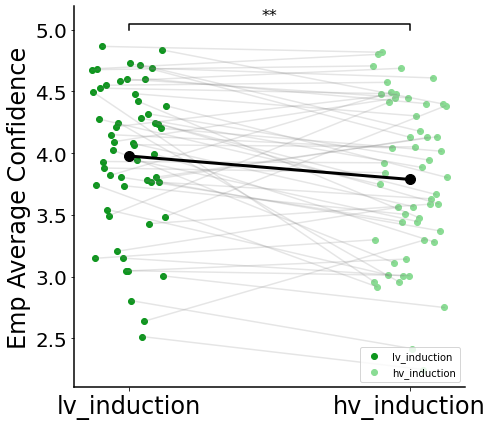

In [7]:
plt.figure(figsize=(7, 7))

color_dict["lv_induction"] = "#0E961E" 
color_dict["hv_induction"] = "#8ADC94"
comparison_plot(
    avg_emp_conf,
    "cj",
    data_list_names,
    "",
    [["lv_induction", "hv_induction"]],
    [5],
    [0.05],
    y_label="Emp Average Confidence",
    legend="lower right",
)


In [8]:
avg_emp_conf

,subject,cj,cor,model,x_idx
0,45628,4.676476,0.950000,lv_induction,1
1,45640,4.494590,0.940000,lv_induction,2
2,45664,3.148277,0.745000,lv_induction,3
3,45682,3.741547,0.825000,lv_induction,4
4,45745,4.684585,0.932500,lv_induction,5
...,...,...,...,...,...
103,47431,4.016351,0.746867,hv_induction,250
104,47470,4.399357,0.804511,hv_induction,251
105,47737,2.750151,0.739348,hv_induction,252
106,47740,4.383498,0.789474,hv_induction,253


Statistics=479.0, p=0.023280950802458164
0.02033035561829085
0.02049987704417007


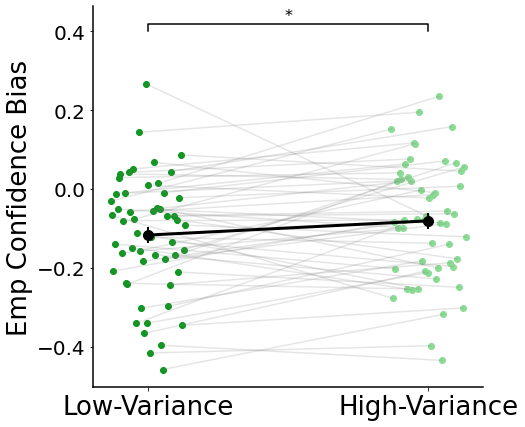

In [233]:
avg_emp_conf["conf_bias"] = linear_transform_on_array(avg_emp_conf["cj"], [1,5], [0,1]) - avg_emp_conf["cor"]

plt.figure(figsize=(7, 7))

color_dict["lv_induction"] = "#0E961E" 
color_dict["hv_induction"] = "#8ADC94"
comparison_plot(
    avg_emp_conf,
    "conf_bias",
    data_list_names,
    "",
    [["lv_induction", "hv_induction"]],
    [.4],
    [0.02],
    y_label="Emp Confidence Bias",
    legend="lower right",
)

plt.savefig("../figs/cross_task_emp_conf_bias.png", dpi=400, bbox_inches='tight')


(p = 1.15e-08, r = 0.68, ci = [0.51,0.80])


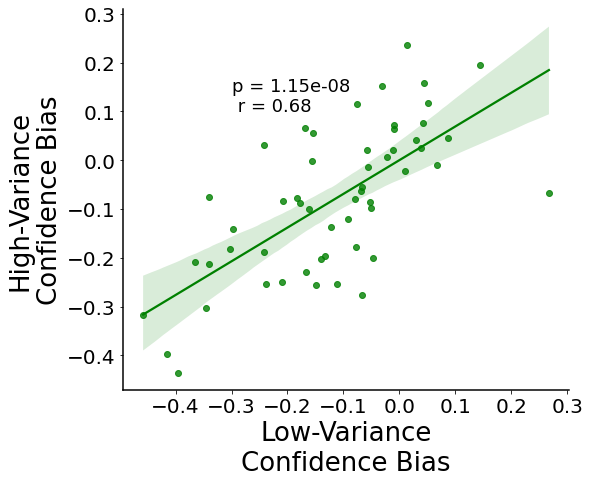

In [438]:
plt.figure(figsize=(8, 7))
avg_emp_conf_lv = avg_emp_conf[avg_emp_conf["model"] == "lv_induction"]
avg_emp_conf_hv = avg_emp_conf[avg_emp_conf["model"] == "hv_induction"]


res = scipy.stats.pearsonr(avg_emp_conf_lv["conf_bias"], avg_emp_conf_hv["conf_bias"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(x=avg_emp_conf_lv["conf_bias"], y=avg_emp_conf_hv["conf_bias"], color="green")

plt.ylabel("High-Variance\nConfidence Bias", fontsize=26)
plt.xlabel("Low-Variance\nConfidence Bias", fontsize=26)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(-.3, .1, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/cross_task_emp_avg_corr.png", dpi=400, bbox_inches='tight')


plt.show()

In [439]:
avg_emp_conf_lv

,subject,cj,cor,model,x_idx,conf_bias
0,45628,4.676476,0.9500,lv_induction,1,-0.030881
1,45640,4.494590,0.9400,lv_induction,2,-0.066352
2,45664,3.148277,0.7450,lv_induction,3,-0.207931
3,45682,3.741547,0.8250,lv_induction,4,-0.139613
4,45745,4.684585,0.9325,lv_induction,5,-0.011354
5,45760,4.276919,0.8700,lv_induction,6,-0.050770
6,45763,4.526510,0.8525,lv_induction,7,0.029127
7,45805,4.865320,0.9275,lv_induction,8,0.038830
8,45829,3.932559,0.8950,lv_induction,9,-0.161860
9,45964,3.879826,0.8000,lv_induction,10,-0.080044


(p = 4.86e-09, r = 0.70, ci = [0.53,0.81])


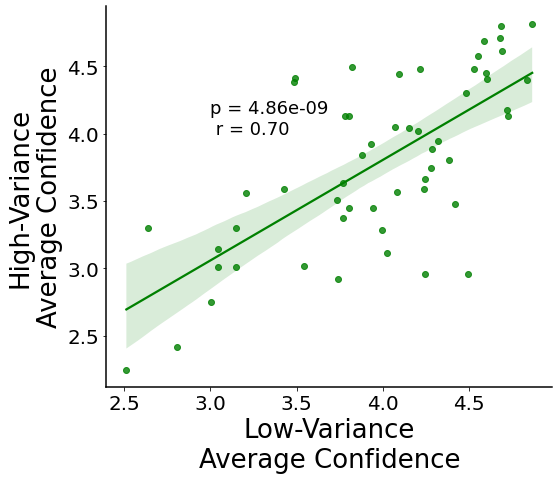

In [444]:
plt.figure(figsize=(8, 7))
avg_emp_conf_lv = avg_emp_conf[avg_emp_conf["model"] == "lv_induction"]
avg_emp_conf_hv = avg_emp_conf[avg_emp_conf["model"] == "hv_induction"]


res = scipy.stats.pearsonr(avg_emp_conf_lv["cj"], avg_emp_conf_hv["cj"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(x=avg_emp_conf_lv["cj"], y=avg_emp_conf_hv["cj"], color="green")

plt.ylabel("High-Variance\nAverage Confidence", fontsize=26)
plt.xlabel("Low-Variance\nAverage Confidence", fontsize=26)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(3, 4, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/cross_task_emp_avgconf_corr.png", dpi=400, bbox_inches='tight')


plt.show()

In [406]:
stat

0.6845245073731404

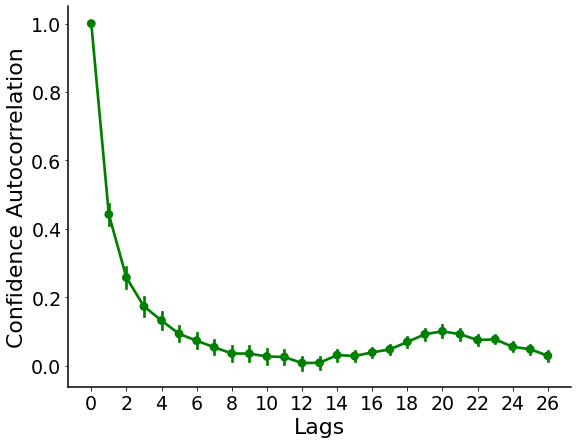

In [479]:
import statsmodels.api as sm
autocorrelations = []
lags = []
subject_cl = []
for sub in subjects:
    subject_data = hv_induction_data[hv_induction_data["sub"] == sub]
    acf = sm.tsa.acf(subject_data["cj"])
    autocorrelations.extend(acf)
    lags.extend(np.arange(len(acf)))
    subject_cl.extend([sub]*len(acf))
auto_corrleation_df = pd.DataFrame(zip(subject_cl,lags, autocorrelations), columns=["subjects","lags", "acf"])

plt.figure(figsize=(9, 7))

seaborn.pointplot(data = auto_corrleation_df, x = "lags", y= "acf", color="green", errorbar="se")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.xticks(fontsize=19)


plt.yticks(fontsize=19)


plt.xlabel("Lags", fontsize=22)
plt.ylabel("Confidence Autocorrelation", fontsize=22)

plt.locator_params(axis='x', nbins=15)


plt.show()

## Fitting

In [4]:
from Forward import forward_fitting

params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
forward_dfs = []
n_fitting = 120
n_threads = 100
for data in data_list:
    res = fit_for_all_subjects(
        params_ranges, n_threads, n_fitting, subjects, data, forward_fitting
    )
    forward_df = make_df_after_fitting(
        res, ["alpha", "beta", "lbound", "bound_range"], subjects
    )
    forward_df["hbound"] = (5 - forward_df["lbound"]) * (
        forward_df["bound_range"]
    ) + forward_df["lbound"]
    forward_dfs.append(forward_df)

In [5]:
from Backward import backward_fitting

params_ranges = [[0, 1], [0, 100], [1, 5], [0.001, 1]]
n_fitting = 120
backward_dfs = []
for data in data_list:
    back_res = fit_for_all_subjects(
        params_ranges, n_threads, n_fitting, subjects, data, backward_fitting
    )
    backward_df = make_df_after_fitting(
        back_res, ["alpha", "beta", "lbound", "bound_range"], subjects
    )
    backward_df["hbound"] = (5 - backward_df["lbound"]) * (
        backward_df["bound_range"]
    ) + backward_df["lbound"]
    backward_dfs.append(backward_df)

In [278]:
back_param_df = merge_result_df(backward_dfs, data_list_names, 200, subjects)
back_param_df["bound_mean"] = (back_param_df["hbound"] + back_param_df["lbound"])/2


Statistics=508.0, p=0.7225336702350214


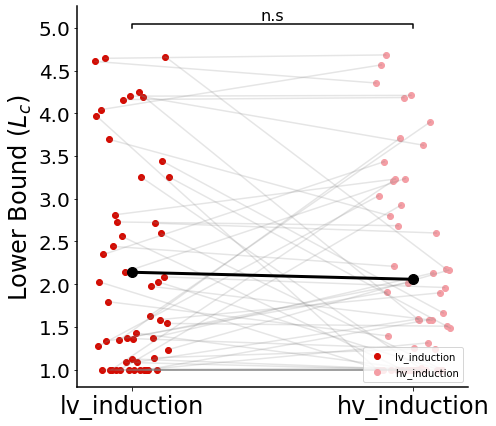

In [279]:
plt.figure(figsize=(7, 7))

 
color_dict["lv_induction"] = "#882255"
color_dict["hv_induction"] = "#CC6677"
comparison_plot(
    back_param_df,
    "lbound",
    data_list_names,
    "",
    [["lv_induction", "hv_induction"]],
    [5],
    [0.05],
    y_label="Lower Bound " + r"$(L_c)$",
    legend="lower right",
)


Statistics=515.0, p=0.11305644746932242


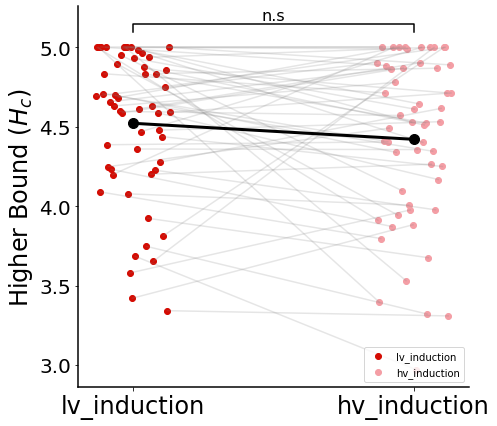

In [280]:
plt.figure(figsize=(7, 7))

color_dict["lv_induction"] = "#D40B02" 
color_dict["hv_induction"] = "#F49EA5"
comparison_plot(
    back_param_df,
    "hbound",
    data_list_names,
    "",
    [["lv_induction", "hv_induction"]],
    [5.1],
    [0.05],
    y_label="Higher Bound " + r"$(H_c)$",
    legend="lower right",
)


Statistics=595.0, p=0.20408208166356445


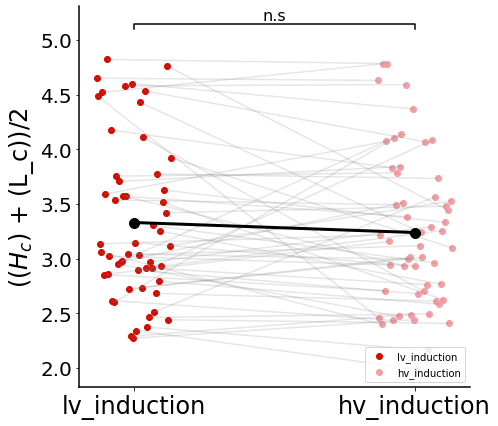

In [281]:
plt.figure(figsize=(7, 7))

color_dict["lv_induction"] = "#D40B02" 
color_dict["hv_induction"] = "#F49EA5"
comparison_plot(
    back_param_df,
    "bound_mean",
    data_list_names,
    "",
    [["lv_induction", "hv_induction"]],
    [5.1],
    [0.05],
    y_label= r"($(H_c)$ + (L_c))/2",
    legend="lower right",
)


Statistics for lv_induction and hv_induction =508.0, p=7.225e-01
mean lv_induction = 2.14
mean hv_induction = 2.06
Statistics for lv_induction and hv_induction =515.0, p=1.131e-01
mean lv_induction = 4.52
mean hv_induction = 4.42
Statistics for lv_induction and hv_induction =595.0, p=2.041e-01
mean lv_induction = 3.33
mean hv_induction = 3.24


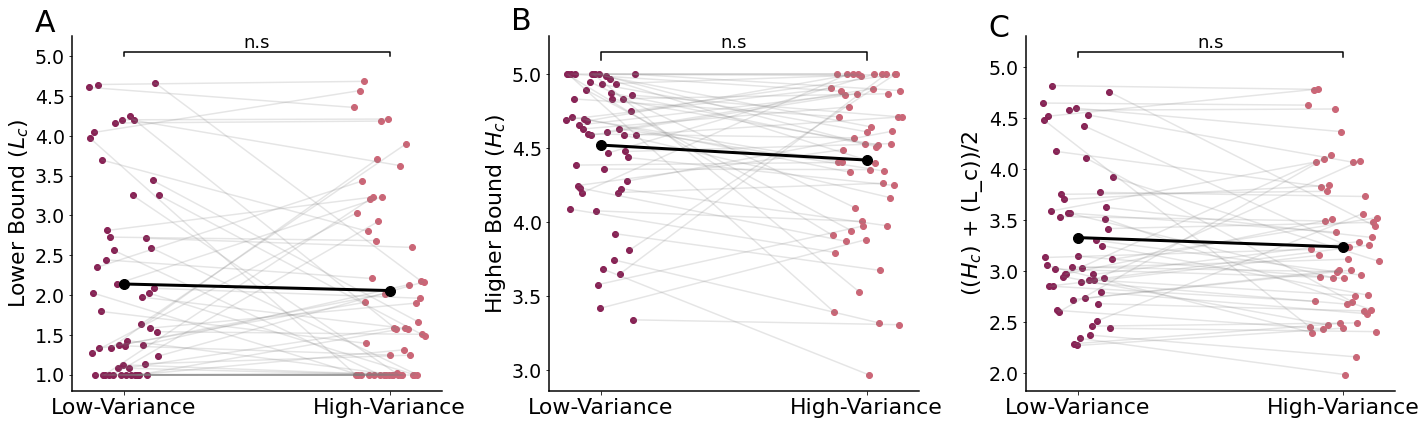

In [298]:
plt.figure(figsize=(20, 6))

color_dict["lv_induction"] = "#882255"
color_dict["hv_induction"] = "#CC6677"

plt.subplot(1,3,1)

plt.text(-40, 5.3, "A", fontsize=30)

comparison_plot(
    back_param_df,
    "lbound",
    data_list_names,
    "",
    [["lv_induction", "hv_induction"]],
    [5],
    [0.05],
    y_label="Lower Bound " + r"$(L_c)$",
    legend="lower right",
    xticks_labels= ["Low-Variance", "High-Variance"]
)

plt.subplot(1,3,2)

plt.text(-40, 5.3, "B", fontsize=30)

comparison_plot(
    back_param_df,
    "hbound",
    data_list_names,
    "",
    [["lv_induction", "hv_induction"]],
    [5.1],
    [0.05],
    y_label="Higher Bound " + r"$(H_c)$",
    legend="lower right",
    xticks_labels= ["Low-Variance", "High-Variance"]
)


plt.subplot(1,3,3)

plt.text(-40, 5.3, "C", fontsize=30)

comparison_plot(
    back_param_df,
    "bound_mean",
    data_list_names,
    "",
    [["lv_induction", "hv_induction"]],
    [5.1],
    [0.05],
    y_label= r"($(H_c)$ + (L_c))/2",
    legend="lower right",
    xticks_labels= ["Low-Variance", "High-Variance"]
)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/Confscales_2con.png", dpi=400, bbox_inches = "tight")

## Auto correlation

In [266]:
from matplotlib.legend_handler import HandlerTuple

def plot_regression_df(df,x, y, color, pos_x, pos_y, xlabel, ylabel):
    

    res = scipy.stats.pearsonr(df[x], df[y])

    stat_fwd_lr, pval= res 
    r_low, r_high = res.confidence_interval(.95)
    print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat_fwd_lr,r_low,r_high))

    seaborn.regplot(data=df, x=x, y=y, color= color, label= "Forwarad Model")

    plt.ylabel(ylabel, fontsize=22)
    plt.xlabel(xlabel, fontsize=22)

    ax = plt.gca()
    # hide x-axis
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(1.5)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    plt.text(pos_x, pos_y, "p = {:.2e} \n r = {:.2f}".format(pval, stat_fwd_lr), fontsize=18)
    

(p = 4.93e-02, r = -0.27,ci = [-0.50,-0.00])
(p = 4.68e-04, r = -0.46,ci = [-0.65,-0.22])


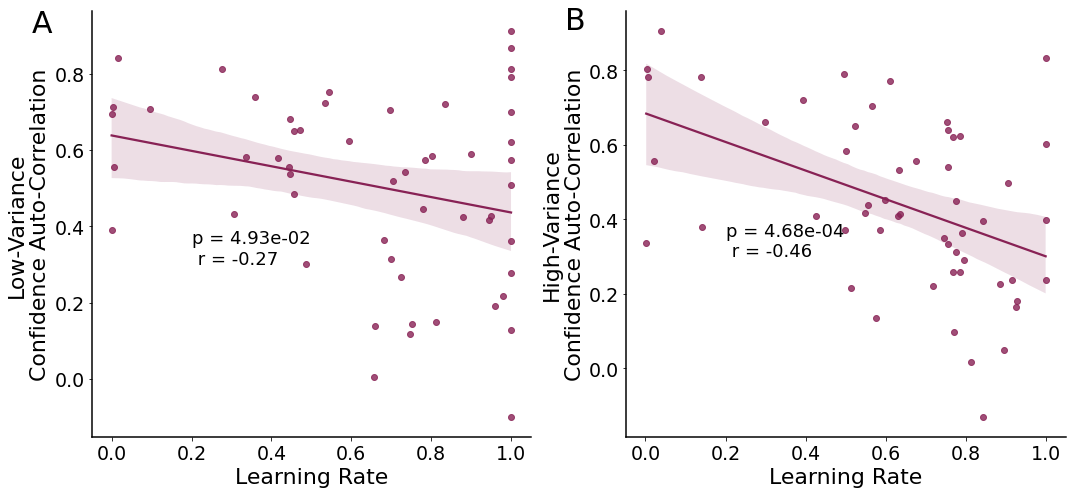

In [277]:
import statsmodels.api as sm
autocorrelations = []
lags = []
subject_cl = []
for sub in subjects:
    subject_data = lv_induction_data[lv_induction_data["sub"] == sub]
    acf = sm.tsa.acf(subject_data["cj"])
    autocorrelations.extend(acf)
    lags.extend(np.arange(len(acf)))
    subject_cl.extend([sub]*len(acf))
auto_corrleation_df_lv = pd.DataFrame(zip(subject_cl,lags, autocorrelations), columns=["subject","lags", "acf"])

temp_df_lag1 = auto_corrleation_df_lv[auto_corrleation_df_lv["lags"] == 1]
temp_df = pd.merge(temp_df_lag1, backward_dfs[0], on = "subject")



fig = plt.figure(figsize=(15, 7))


plt.subplot(1,2,1)
plt.text(-.2, .91, "A", fontsize=30)

plot_regression_df(temp_df,"alpha", "acf", "#882255", .2, .3, "Learning Rate", "Low-Variance\nConfidence Auto-Correlation")


plt.subplot(1,2,2)

plt.text(-.2, .91, "B", fontsize=30)


autocorrelations = []
lags = []
subject_cl = []
for sub in subjects:
    subject_data = hv_induction_data[hv_induction_data["sub"] == sub]
    acf = sm.tsa.acf(subject_data["cj"])
    autocorrelations.extend(acf)
    lags.extend(np.arange(len(acf)))
    subject_cl.extend([sub]*len(acf))
auto_corrleation_df_hv = pd.DataFrame(zip(subject_cl,lags, autocorrelations), columns=["subject","lags", "acf"])

temp_df_lag1 = auto_corrleation_df_hv[auto_corrleation_df_hv["lags"] == 1]
temp_df = pd.merge(temp_df_lag1, backward_dfs[1], on = "subject")


plot_regression_df(temp_df,"alpha", "acf", "#882255", .2, .3, "Learning Rate", "High-Variance\nConfidence Auto-Correlation")

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/Auto-correlation,Alpha,2var.png", dpi=400, bbox_inches='tight')


plt.show()

In [180]:
temp_df_lag1 = auto_corrleation_df_lv[auto_corrleation_df_lv["lags"] == 20]
temp_df = pd.merge(temp_df_lag1, backward_dfs[0], on = "subject")
temp_df = pd.merge(temp_df, forward_dfs[0], on ="subject")
temp_df["alpha_y"].mean()

0.9372165644020941

(p = 3.80e-01, r = -0.12, ci = [-0.38,0.15])


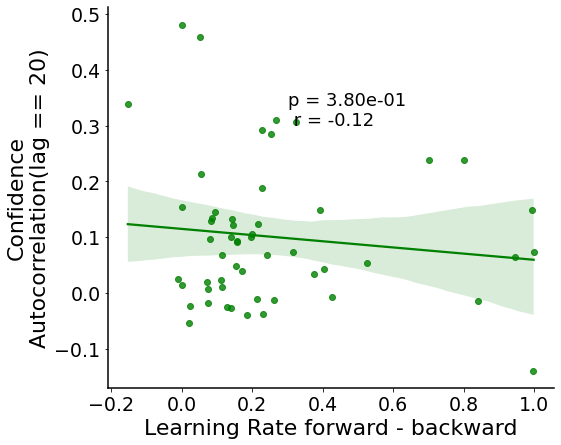

In [213]:
temp_df_lag1 = auto_corrleation_df_lv[auto_corrleation_df_lv["lags"] == 20]
temp_df = pd.merge(temp_df_lag1, backward_dfs[1], on = "subject")
temp_df = pd.merge(temp_df, forward_dfs[1], on ="subject")
temp_df["alpha-dif"] = temp_df["alpha_y"] - temp_df["alpha_x"]

plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(temp_df["alpha-dif"], temp_df["acf"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(data=temp_df, x="alpha-dif", y="acf", color="green")

plt.ylabel("Confidence\nAutocorrelation(lag == 20)", fontsize=22)
plt.xlabel("Learning Rate forward - backward", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(.3, .3, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/autocorr_diffalpha_correlation_lag20_hv.png", dpi=400, bbox_inches='tight')


plt.show()

## Simulation with fitted parameters

In [6]:
from Forward import simulate_with_params

np.random.seed(1)
forward_simulation_dfs = []
backward_simulation_dfs = []
for forward_df, data in zip(forward_dfs, data_list):
    forward_simulation_df = simulate_with_params(forward_df, data, subjects , n = 100)
    forward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
    forward_simulation_dfs.append(forward_simulation_df)

for backward_df, data in zip(backward_dfs, data_list):
    backward_simulation_df = simulate_with_params(backward_df, data, subjects, n= 100)
    backward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
    backward_simulation_dfs.append(backward_simulation_df)

In [175]:
forward_simulation_dfs

[]

In [7]:
forward_avg_dfs = []
for forward_simulation_df, data in zip(forward_simulation_dfs, data_list):
    forward_avg_df = (
        forward_simulation_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    emp_avg_df = data.rename(columns={"sub": "subject"})
    emp_avg_df = (
        emp_avg_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    forward_avg_df.rename(
        columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
        inplace=True,
    )
    forward_avg_df = pd.merge(forward_avg_df, emp_avg_df, on=["subject"])

    forward_avg_df["fwd_emp"] = forward_avg_df["accuracy"] - forward_avg_df["cor"]
    forward_avg_dfs.append(forward_avg_df)

groups = ["lv_induction", "hv_induction", "lv_test", "hv_test"]
df = merge_result_df(forward_avg_dfs, groups, 200, subjects)

In [8]:
gr1 = "lv_induction"
gr2 = "hv_induction"




Statistics=125.0, p=1.05588169887459e-07


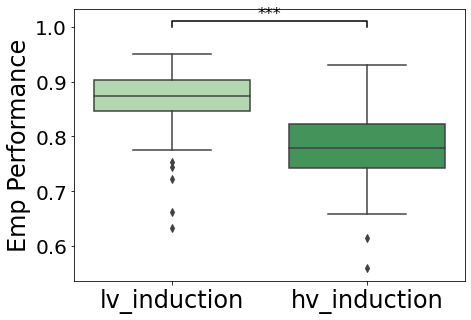

In [9]:
plt.figure(figsize=(7, 5))

y_column = "cor"
gr1_data = df.query("model=='{}'".format(gr1))
gr2_data = df.query("model=='{}'".format(gr2))

seaborn.boxplot(data=df, x= "model", y=y_column, palette ="Greens")

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)



plt.plot([0,0, 1,1], [1,1.01, 1.01,1], lw=1.5, c="k")
plt.text(.5, 1.01, symb, ha='center', va='bottom', fontsize=16)
        

plt.title("", fontsize=12)
plt.ylabel("Emp Performance", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax = plt.gca()
plt.xlabel("")
plt.show()

Statistics=57.0, p=3.5845890902721695e-09


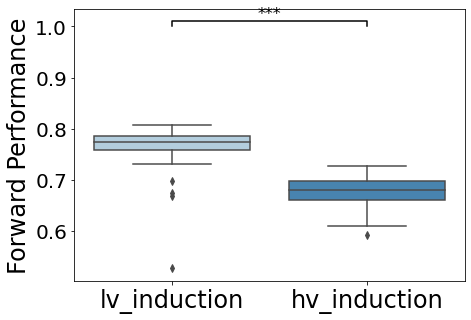

In [10]:
plt.figure(figsize=(7, 5))

y_column = "accuracy"
seaborn.boxplot(data=df, x= "model", y=y_column, palette ="Blues")

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.plot([0,0, 1,1], [1,1.01, 1.01,1], lw=1.5, c="k")
plt.text(.5, 1.01, symb, ha='center', va='bottom', fontsize=16)
        

plt.title("", fontsize=12)
plt.ylabel("Forward Performance", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax = plt.gca()
plt.xlabel("")
plt.show()

In [11]:
backward_avg_dfs = []
for backward_simulation_df, data in zip(backward_simulation_dfs, data_list):
    backward_avg_df = (
        backward_simulation_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    emp_avg_df = data.rename(columns={"sub": "subject"})
    emp_avg_df = (
        emp_avg_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    backward_avg_df.rename(
        columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
        inplace=True,
    )
    backward_avg_df = pd.merge(backward_avg_df, emp_avg_df, on=["subject"])

    backward_avg_df["fwd_emp"] = backward_avg_df["accuracy"] - backward_avg_df["cor"]
    backward_avg_dfs.append(backward_avg_df)

groups = ["lv_induction", "hv_induction", "lv_test", "hv_test"]
back_df = merge_result_df(backward_avg_dfs, groups, 200, subjects)

Statistics=207.0, p=4.011768559349753e-06


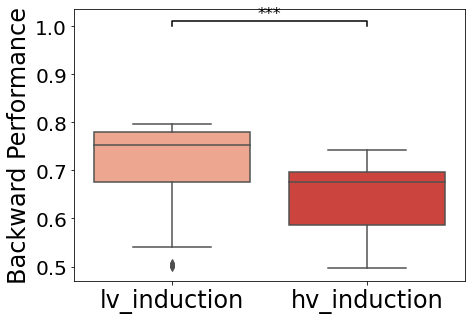

In [12]:
plt.figure(figsize=(7, 5))

y_column = "accuracy"

seaborn.boxplot(data=back_df, x= "model", y=y_column, palette ="Reds")

gr1_data = back_df.query("model=='{}'".format(gr1))
gr2_data = back_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))


print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.plot([0,0, 1,1], [1,1.01, 1.01,1], lw=1.5, c="k")
plt.text(.5, 1.01, symb, ha='center', va='bottom', fontsize=16)
        

plt.title("", fontsize=12)
plt.ylabel("Backward Performance", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax = plt.gca()
plt.xlabel("")
plt.show()

In [13]:
dfs = []
for backward_simulation_df, forward_simulation_df in zip(
    backward_simulation_dfs, forward_simulation_dfs
):
    backward_avg_df = (
        backward_simulation_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    forward_avg_df = (
        forward_simulation_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    backward_avg_df.rename(
        columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
        inplace=True,
    )
    backward_avg_df = pd.merge(backward_avg_df, forward_avg_df, on=["subject"])

    backward_avg_df["mrl_ratio"] = backward_avg_df["accuracy"] / backward_avg_df["cor"]
    dfs.append(backward_avg_df)

groups = ["lv_induction", "hv_induction", "lv_test", "hv_test"]
mrl_df = merge_result_df(dfs, groups, 200, subjects)

Statistics=627.0, p=0.3199891506452244


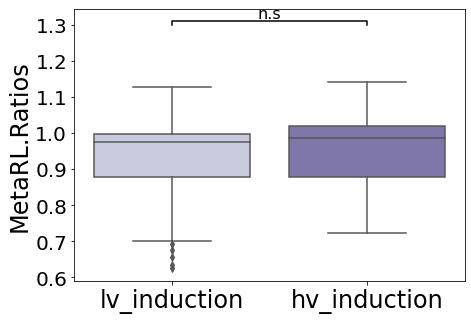

In [14]:
plt.figure(figsize=(7, 5))

y_column = "mrl_ratio"

seaborn.boxplot(data=mrl_df, x= "model", y=y_column, palette ="Purples")

gr1_data = mrl_df.query("model=='{}'".format(gr1))
gr2_data = mrl_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))


print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.plot([0,0, 1,1], [1.3,1.31, 1.31,1.3], lw=1.5, c="k")
plt.text(.5, 1.31, symb, ha='center', va='bottom', fontsize=16)
        

plt.title("", fontsize=12)
plt.ylabel("MetaRL.Ratios", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax = plt.gca()
plt.xlabel("")
plt.show()

In [15]:
green_pal =seaborn.cubehelix_palette(2, start=2, rot=0, dark=.4, light=.6, reverse=True)
green_pal

[[0.2589165655259408, 0.4893931233545494, 0.30529887999999994],
 [0.4589165655259408, 0.6893931233545493, 0.5052988799999999]]

Statistics=57.0, p=3.5845890902721695e-09
Statistics=57.0, p=3.5845890902721695e-09
Statistics=207.0, p=4.011768559349753e-06
Statistics=627.0, p=0.3199891506452244


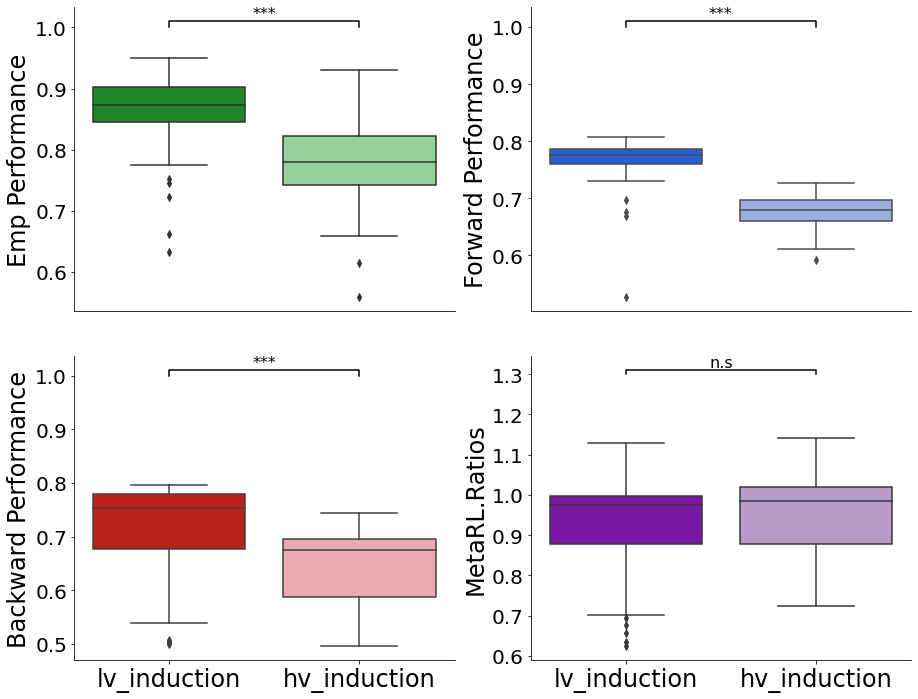

In [16]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)

green_pal = ["#0E961E", "#8ADC94"]
blue_pal = ["#0957F1", "#8DACEC"]
red_pal = ["#D40B02", "#F49EA5"]
purple_pal = ["#8301BB", "#BA92D0"]

y_column = "cor"
seaborn.boxplot(data=df, x= "model", y=y_column, palette = green_pal)

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

gr1_data = df.query("model=='{}'".format(gr1))
gr2_data = df.query("model=='{}'".format(gr2))


plt.plot([0,0, 1,1], [1,1.01, 1.01,1], lw=1.5, c="k")
plt.text(.5, 1.01, symb, ha='center', va='bottom', fontsize=16)
        

plt.title("", fontsize=12)
plt.ylabel("Emp Performance", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks([])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("")

plt.subplot(2, 2, 2)

y_column = "accuracy"
seaborn.boxplot(data=df, x= "model", y=y_column, palette = blue_pal)

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.plot([0,0, 1,1], [1,1.01, 1.01,1], lw=1.5, c="k")
plt.text(.5, 1.01, symb, ha='center', va='bottom', fontsize=16)
        

plt.title("", fontsize=12)
plt.ylabel("Forward Performance", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks([])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("")


plt.subplot(2, 2, 3)

y_column = "accuracy"

seaborn.boxplot(data=back_df, x= "model", y=y_column, palette = red_pal)

gr1_data = back_df.query("model=='{}'".format(gr1))
gr2_data = back_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))


print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.plot([0,0, 1,1], [1,1.01, 1.01,1], lw=1.5, c="k")
plt.text(.5, 1.01, symb, ha='center', va='bottom', fontsize=16)
        

plt.title("", fontsize=12)
plt.ylabel("Backward Performance", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("")

plt.subplot(2, 2, 4)

y_column = "mrl_ratio"

seaborn.boxplot(data=mrl_df, x= "model", y=y_column, palette = purple_pal)

gr1_data = mrl_df.query("model=='{}'".format(gr1))
gr2_data = mrl_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))


print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.plot([0,0, 1,1], [1.3,1.31, 1.31,1.3], lw=1.5, c="k")
plt.text(.5, 1.31, symb, ha='center', va='bottom', fontsize=16)
        

plt.title("", fontsize=12)
plt.ylabel("MetaRL.Ratios", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax = plt.gca()
plt.xlabel("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.subplots_adjust(
                    wspace=0.2,
                    hspace=0.15)

plt.show()

Statistics=400.0, p=0.003188043227642762
0.08089567747015836
0.08677975342988589


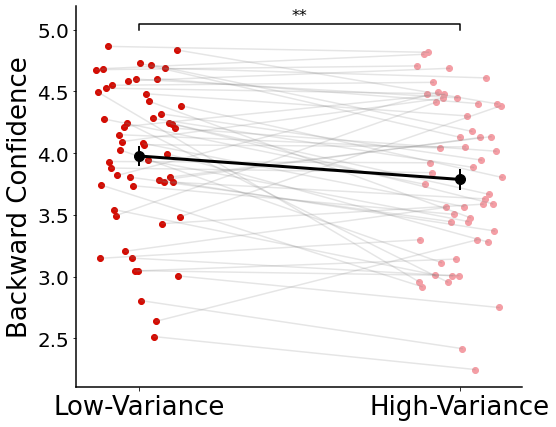

In [216]:
plt.figure(figsize=(8, 7))

color_dict["lv_induction"] = "#D40B02" 
color_dict["hv_induction"] = "#F49EA5"

comparison_plot(
    back_df,
    "cj",
    groups,
    "",
    [["lv_induction", "hv_induction"]],
    [5],
    [0.05],
    y_label="Backward Confidence",
    legend="lower right",
)

plt.savefig("../figs/cross_task_avg_conf_compare.png", dpi=400, bbox_inches='tight')


In [77]:
emp_df

,subject,Performance,task,model
0,45628,0.950000,lv_induction,Empirical
1,45640,0.940000,lv_induction,Empirical
2,45664,0.745000,lv_induction,Empirical
3,45682,0.825000,lv_induction,Empirical
4,45745,0.932500,lv_induction,Empirical
...,...,...,...,...
103,47431,0.746867,hv_induction,Empirical
104,47470,0.804511,hv_induction,Empirical
105,47737,0.739348,hv_induction,Empirical
106,47740,0.789474,hv_induction,Empirical


Statistics=125.0, p=1.05588169887459e-07
Statistics=57.0, p=3.5845890902721695e-09
Statistics=207.0, p=4.011768559349753e-06


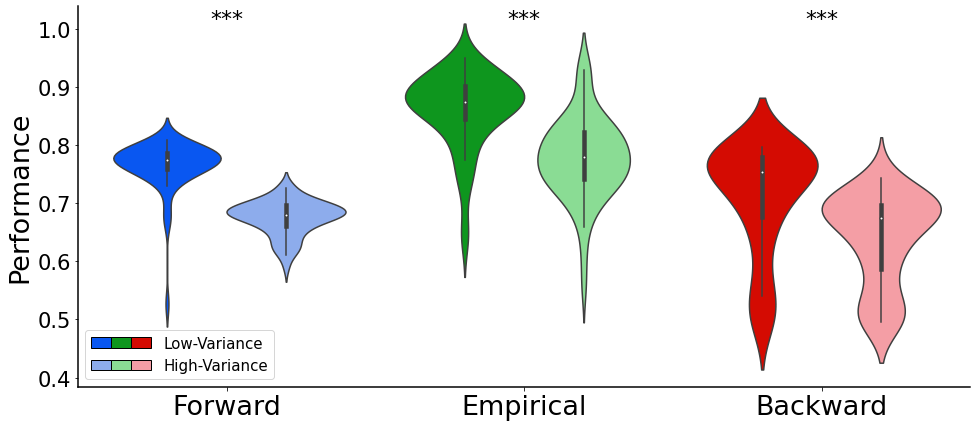

In [92]:
from seaborn import violinplot
from matplotlib.collections import PolyCollection

from matplotlib.legend_handler import HandlerTuple

fig, ax = plt.subplots(figsize=(16, 7))

colors = [ "#0957F1", "#8DACEC", "#0E961E", "#8ADC94", "#D40B02", "#F49EA5"]

emp_df = df[["subject", "cor", "model"]]
emp_df = emp_df.rename(columns= {"model": "task", "cor": "Performance"})
emp_df["model"] = "Empirical"

fwd_df = df[["subject", "accuracy", "model"]]
fwd_df = fwd_df.rename(columns= {"model": "task", "accuracy": "Performance"})
fwd_df["model"] = "Forward"


bck_df = back_df[["subject", "accuracy", "model"]]
bck_df = bck_df.rename(columns= {"model": "task", "accuracy": "Performance"})
bck_df["model"] = "Backward"

violin_df = pd.concat([ fwd_df, emp_df, bck_df])


ax = seaborn.violinplot(data=violin_df, x="model", y="Performance", hue = "task")

# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)

handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance", "High-Variance"], handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "lower left")

ax.get_legend()


for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=27)
plt.yticks(fontsize=21)

ax.set_xticklabels(["Forward" ,"Empirical", "Backward"])

plt.ylabel("Performance", fontsize=27)
plt.xlabel("", fontsize=27)


gr1_data = emp_df.query("task=='{}'".format(gr1))
gr2_data = emp_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["Performance"]), np.array(gr2_data["Performance"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 1, 1.0,symb , ha='center', va='bottom', fontsize=22)

gr1_data = fwd_df.query("task=='{}'".format(gr1))
gr2_data = fwd_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["Performance"]), np.array(gr2_data["Performance"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 0, 1.0,symb , ha='center', va='bottom', fontsize=22)

gr1_data = bck_df.query("task=='{}'".format(gr1))
gr2_data = bck_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["Performance"]), np.array(gr2_data["Performance"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 2, 1.0,symb , ha='center', va='bottom', fontsize=22)


# plt.savefig("../figs/cross_task_perf_violin.png", dpi=400, bbox_inches='tight')


plt.show()

In [142]:
params_df

,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound,model,x_idx,task
0,45628.0,1.000000,11.609160,4.605658,0.227874,137.997922,0.774465,4.695518,forward,1,induction
1,45640.0,0.712177,16.827743,4.462571,0.071960,114.860509,0.418840,4.501244,forward,2,induction
2,45664.0,1.000000,9.946770,3.148277,0.000000,164.286110,1.549730,3.148277,forward,3,induction
3,45682.0,1.000000,10.014854,1.488940,0.821553,144.475233,0.728441,4.373464,forward,4,induction
4,45745.0,1.000000,9.672207,4.092176,0.945758,188.692218,0.437737,4.950758,forward,5,induction
...,...,...,...,...,...,...,...,...,...,...,...
211,47431.0,0.719021,4.520113,1.960070,1.000000,171.880035,0.622341,5.000000,backward,650,induction
212,47470.0,1.000000,16.279409,2.176431,0.898570,112.036760,0.686963,4.713606,backward,651,induction
213,47737.0,0.566020,4.811324,1.506758,0.515835,161.206712,0.905014,3.308693,backward,652,induction
214,47740.0,0.597513,12.182257,2.163447,0.961255,113.127618,1.017667,4.890097,backward,653,induction


Statistics=479.0, p=0.023280950802458164
Statistics=411.0, p=0.004313350898602614
Statistics=619.0, p=0.2876178536082771


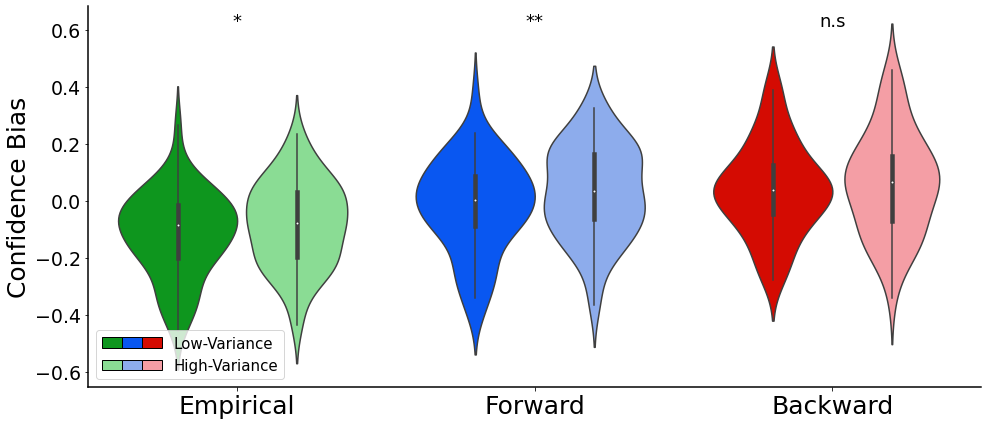

In [485]:
from seaborn import violinplot
from matplotlib.collections import PolyCollection

from matplotlib.legend_handler import HandlerTuple

fig, ax = plt.subplots(figsize=(16, 7))

y_columns = "Conf_bias"
colors = ["#0E961E", "#8ADC94", "#0957F1", "#8DACEC", "#D40B02", "#F49EA5"]

emp_df = avg_emp_conf[["subject", "conf_bias", "model"]]
emp_df = emp_df.rename(columns= {"model": "task", "conf_bias": y_columns})
emp_df["model"] = "Empirical"

fwd_df = fwd_conf_df[["subject", "conf_bias", "model"]]
fwd_df = fwd_df.rename(columns= {"model": "task", "conf_bias": y_columns})
fwd_df["model"] = "Forward"


bck_df = back_df[["subject", "conf_bias", "model"]]
bck_df = bck_df.rename(columns= {"model": "task", "conf_bias": y_columns})
bck_df["model"] = "Backward"

violin_df = pd.concat([emp_df, fwd_df, bck_df])


ax = seaborn.violinplot(data=violin_df, x="model", y= y_columns, hue = "task")

# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)
handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance", "High-Variance"], handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "lower left")


for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=25)
plt.yticks(fontsize=19)

ax.set_xticklabels(["Empirical", "Forward", "Backward"])

plt.ylabel("Confidence Bias", fontsize=25)
plt.xlabel("", fontsize=25)


gr1_data = emp_df.query("task=='{}'".format(gr1))
gr2_data = emp_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 0, .6,symb , ha='center', va='bottom', fontsize=18)

gr1_data = fwd_df.query("task=='{}'".format(gr1))
gr2_data = fwd_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 1, .6,symb , ha='center', va='bottom', fontsize=18)

gr1_data = bck_df.query("task=='{}'".format(gr1))
gr2_data = bck_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 2, .6,symb , ha='center', va='bottom', fontsize=18)


plt.savefig("../figs/cross_task_confbias_violin.png", dpi=400, bbox_inches='tight')


plt.show()

Statistics=686.0, p=0.6266287840602375
Statistics=649.0, p=0.4207877211928708
Statistics=597.0, p=0.21028333642837127


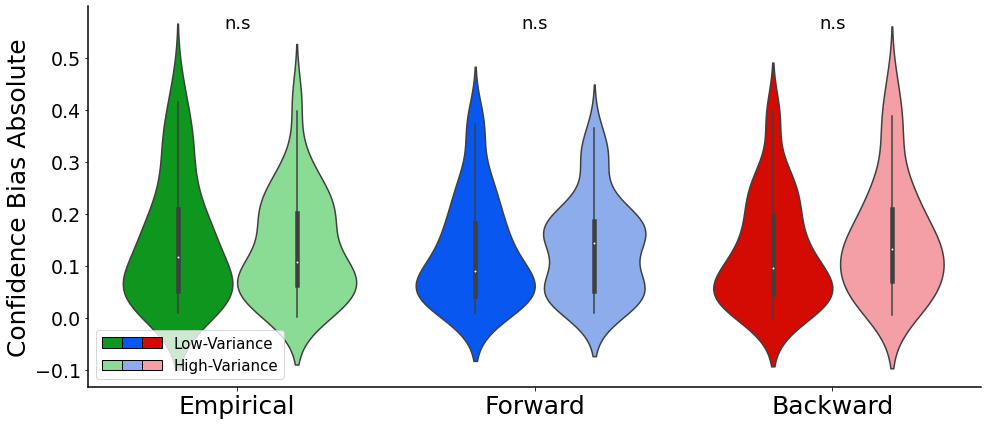

In [488]:
from seaborn import violinplot
from matplotlib.collections import PolyCollection

from matplotlib.legend_handler import HandlerTuple

fig, ax = plt.subplots(figsize=(16, 7))

y_columns = "conf_bias_abs"
colors = ["#0E961E", "#8ADC94", "#0957F1", "#8DACEC", "#D40B02", "#F49EA5"]

emp_df = avg_emp_conf[["subject", "conf_bias", "model"]]
emp_df = emp_df.rename(columns= {"model": "task"})
emp_df["model"] = "Empirical"
emp_df["conf_bias_abs"] = np.abs(emp_df["conf_bias"])

fwd_df = fwd_conf_df[["subject", "conf_bias", "model"]]
fwd_df = fwd_df.rename(columns= {"model": "task"})
fwd_df["model"] = "Forward"
fwd_df["conf_bias_abs"] = np.abs(fwd_df["conf_bias"])



bck_df = back_df[["subject", "conf_bias", "model"]]
bck_df = bck_df.rename(columns= {"model": "task"})
bck_df["model"] = "Backward"
bck_df["conf_bias_abs"] = np.abs(bck_df["conf_bias"])


violin_df = pd.concat([emp_df, fwd_df, bck_df])


ax = seaborn.violinplot(data=violin_df, x="model", y= y_columns, hue = "task")

# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)
handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance", "High-Variance"], handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "lower left")


for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=25)
plt.yticks(fontsize=19)

ax.set_xticklabels(["Empirical", "Forward", "Backward"])

plt.ylabel("Confidence Bias Absolute", fontsize=25)
plt.xlabel("", fontsize=25)


gr1_data = emp_df.query("task=='{}'".format(gr1))
gr2_data = emp_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 0, .55,symb , ha='center', va='bottom', fontsize=18)

gr1_data = fwd_df.query("task=='{}'".format(gr1))
gr2_data = fwd_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 1, .55,symb , ha='center', va='bottom', fontsize=18)

gr1_data = bck_df.query("task=='{}'".format(gr1))
gr2_data = bck_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 2, .55,symb , ha='center', va='bottom', fontsize=18)


plt.savefig("../figs/cross_task_confbias_abs_violin.png", dpi=400, bbox_inches='tight')


plt.show()

Statistics=400.0, p=0.003188043227642762
Statistics=443.0, p=0.009915556661071844
Statistics=438.0, p=0.008746382294012317


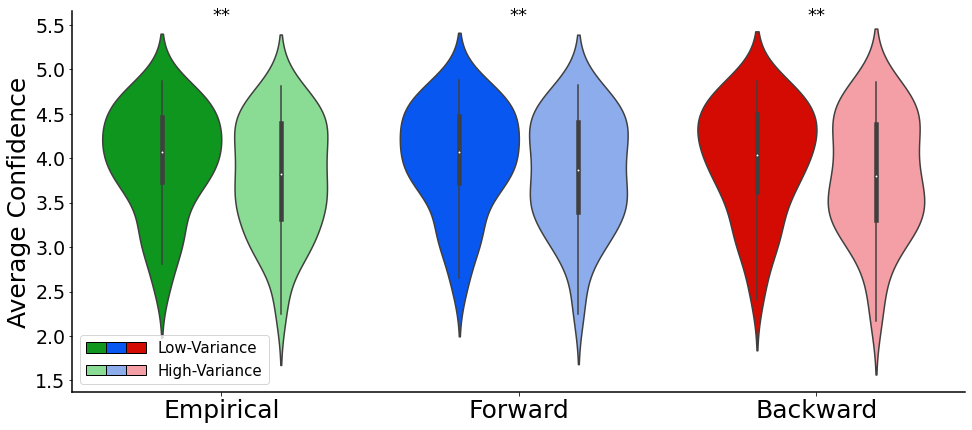

In [482]:
from seaborn import violinplot
from matplotlib.collections import PolyCollection

from matplotlib.legend_handler import HandlerTuple

fig, ax = plt.subplots(figsize=(16, 7))

y_columns = "Conf"
colors = ["#0E961E", "#8ADC94", "#0957F1", "#8DACEC", "#D40B02", "#F49EA5"]

emp_df = df[["subject", "cj", "model"]]
emp_df = emp_df.rename(columns= {"model": "task", "cj": y_columns})
emp_df["model"] = "Empirical"

fwd_df = df[["subject", "mean conf", "model"]]
fwd_df = fwd_df.rename(columns= {"model": "task", "mean conf": y_columns})
fwd_df["model"] = "Forward"


bck_df = back_df[["subject", "mean conf", "model"]]
bck_df = bck_df.rename(columns= {"model": "task", "mean conf": y_columns})
bck_df["model"] = "Backward"

violin_df = pd.concat([emp_df, fwd_df, bck_df])


ax = seaborn.violinplot(data=violin_df, x="model", y= y_columns, hue = "task")

# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)
handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance", "High-Variance"], handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "lower left")


for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=25)
plt.yticks(fontsize=19)

ax.set_xticklabels(["Empirical", "Forward", "Backward"])

plt.ylabel("Average Confidence", fontsize=25)
plt.xlabel("", fontsize=25)


gr1_data = emp_df.query("task=='{}'".format(gr1))
gr2_data = emp_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 0, 5.5,symb , ha='center', va='bottom', fontsize=18)

gr1_data = fwd_df.query("task=='{}'".format(gr1))
gr2_data = fwd_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 1, 5.5,symb , ha='center', va='bottom', fontsize=18)

gr1_data = bck_df.query("task=='{}'".format(gr1))
gr2_data = bck_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 2, 5.5,symb , ha='center', va='bottom', fontsize=18)


plt.savefig("../figs/cross_task_avgconf_violin.png", dpi=400, bbox_inches='tight')


plt.show()

In [462]:
violin_df

,subject,Conf_bias,task,model
0,45628,-0.030881,lv_induction,Empirical
1,45640,-0.066352,lv_induction,Empirical
2,45664,-0.207931,lv_induction,Empirical
3,45682,-0.139613,lv_induction,Empirical
4,45745,-0.011354,lv_induction,Empirical
...,...,...,...,...
103,47431,0.054173,hv_induction,Backward
104,47470,0.246652,hv_induction,Backward
105,47737,-0.239733,hv_induction,Backward
106,47740,0.131425,hv_induction,Backward


In [225]:
params_df["task"] = "induction"
params_df.loc[params_df["model"] == "forward_lv_inuction", "task"] = "lv_inuction"
params_df.loc[params_df["model"] == "forward_hv_inuction", "task"] = "hv_inuction"
params_df.loc[params_df["model"] == "backward_lv_inuction", "task"] = "lv_inuction"
params_df.loc[params_df["model"] == "backward_hv_inuction", "task"] = "hv_inuction"

params_df.loc[params_df["model"] == "forward_lv_inuction", "model"] = "forward"
params_df.loc[params_df["model"] == "forward_hv_inuction", "model"] = "forward"
params_df.loc[params_df["model"] == "backward_lv_inuction", "model"] = "backward"
params_df.loc[params_df["model"] == "backward_hv_inuction", "model"] = "backward"


forward_params_df.loc[forward_params_df["model"] == "forward_lv_inuction", "task"] = "lv_inuction"
forward_params_df.loc[forward_params_df["model"] == "forward_hv_inuction", "task"] = "hv_inuction"
backward_params_df.loc[backward_params_df["model"] == "backward_lv_inuction", "task"] = "lv_inuction"
backward_params_df.loc[backward_params_df["model"] == "backward_hv_inuction", "task"] = "hv_inuction"

params_df

,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound,model,x_idx,task
0,45628.0,1.000000,11.609160,4.605658,0.227874,137.997922,0.774465,4.695518,forward,1,lv_inuction
1,45640.0,0.712177,16.827743,4.462571,0.071960,114.860509,0.418840,4.501244,forward,2,lv_inuction
2,45664.0,1.000000,9.946770,3.148277,0.000000,164.286110,1.549730,3.148277,forward,3,lv_inuction
3,45682.0,1.000000,10.014854,1.488940,0.821553,144.475233,0.728441,4.373464,forward,4,lv_inuction
4,45745.0,1.000000,9.672207,4.092176,0.945758,188.692218,0.437737,4.950758,forward,5,lv_inuction
...,...,...,...,...,...,...,...,...,...,...,...
211,47431.0,0.719021,4.520113,1.960070,1.000000,171.880035,0.622341,5.000000,backward,650,hv_inuction
212,47470.0,1.000000,16.279409,2.176431,0.898570,112.036760,0.686963,4.713606,backward,651,hv_inuction
213,47737.0,0.566020,4.811324,1.506758,0.515835,161.206712,0.905014,3.308693,backward,652,hv_inuction
214,47740.0,0.597513,12.182257,2.163447,0.961255,113.127618,1.017667,4.890097,backward,653,hv_inuction


In [226]:
backward_params_df

,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound,model,x_idx,task
0,45628.0,1.000000,13.259451,4.606821,0.221290,139.033163,0.774456,4.693827,backward_lv_inuction,1,lv_inuction
1,45640.0,0.003908,100.000000,3.968331,1.000000,275.681213,0.410537,5.000000,backward_lv_inuction,2,lv_inuction
2,45664.0,0.001108,100.000000,1.270128,1.000000,275.198525,1.536389,5.000000,backward_lv_inuction,3,lv_inuction
3,45682.0,0.658564,57.058426,2.026064,0.693936,453.480850,0.705934,4.089785,backward_lv_inuction,4,lv_inuction
4,45745.0,1.000000,7.876815,4.041896,1.000000,190.566010,0.437457,5.000000,backward_lv_inuction,5,lv_inuction
...,...,...,...,...,...,...,...,...,...,...,...
103,47431.0,0.719021,4.520113,1.960070,1.000000,171.880035,0.622341,5.000000,backward_hv_inuction,250,hv_inuction
104,47470.0,1.000000,16.279409,2.176431,0.898570,112.036760,0.686963,4.713606,backward_hv_inuction,251,hv_inuction
105,47737.0,0.566020,4.811324,1.506758,0.515835,161.206712,0.905014,3.308693,backward_hv_inuction,252,hv_inuction
106,47740.0,0.597513,12.182257,2.163447,0.961255,113.127618,1.017667,4.890097,backward_hv_inuction,253,hv_inuction


In [227]:
col = "beta"
a = forward_params_df[(forward_params_df["task"] == "lv_inuction")][col].to_numpy() - forward_params_df[(forward_params_df["task"] == "hv_inuction")][col].to_numpy()
b= backward_params_df[(backward_params_df["task"] == "lv_inuction")][col].to_numpy() - backward_params_df[(backward_params_df["task"] == "hv_inuction")][col].to_numpy()

stat, p = scipy.stats.wilcoxon(a, b)

print('Statistics={}, p={}'.format(stat, p))


Statistics=678.0, p=0.5786490889310159


In [228]:
a = forward_params_df[(forward_params_df["task"] == "lv_induction")][col].to_numpy() - forward_params_df[(forward_params_df[""] == "hv_induction")][col].to_numpy()
a

KeyError: ''

In [257]:
gr1 = "lv_inuction"
gr2 = "hv_inuction"

Statistics=288.0, p=0.04091907995939848
Statistics=655.0, p=0.7568384093735303


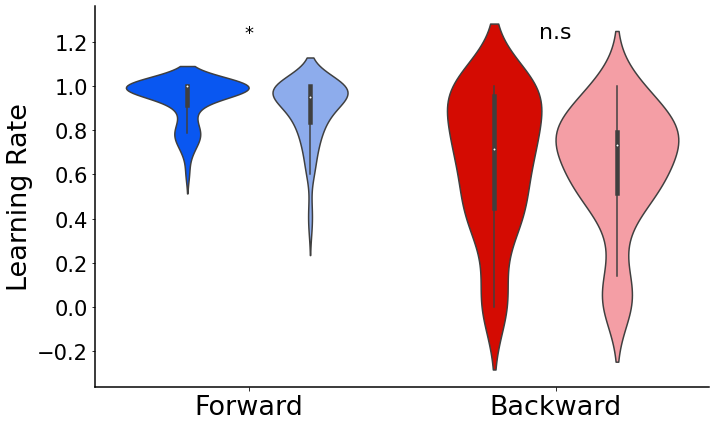

In [230]:
from seaborn import violinplot
from matplotlib.collections import PolyCollection

from matplotlib.legend_handler import HandlerTuple

fig, ax = plt.subplots(figsize=(11, 7))

colors = ["#0957F1", "#8DACEC", "#D40B02", "#F49EA5"]


ax = seaborn.violinplot(data=params_df, x="model", y="alpha", hue = "task")

# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)
handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

# ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance", "High-Variance"], handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
#          , loc = "lower left")

ax.get_legend().remove()

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=27)
plt.yticks(fontsize=21)

ax.set_xticklabels(["Forward", "Backward"])

plt.ylabel("Learning Rate", fontsize=27)
plt.xlabel("", fontsize=25)



gr1_data = forward_params_df.query("task=='{}'".format(gr1))
gr2_data = forward_params_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["alpha"]), np.array(gr2_data["alpha"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 0, 1.2,symb , ha='center', va='bottom', fontsize=18)

gr1_data = backward_params_df.query("task=='{}'".format(gr1))
gr2_data = backward_params_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["alpha"]), np.array(gr2_data["alpha"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 1, 1.2,symb , ha='center', va='bottom', fontsize=22)


plt.savefig("../figs/cross_task_perf_violin_lr.png", dpi=400, bbox_inches='tight')


plt.show()

Statistics=166.0, p=6.913045006177087e-07
Statistics=420.0, p=0.008896865621109945


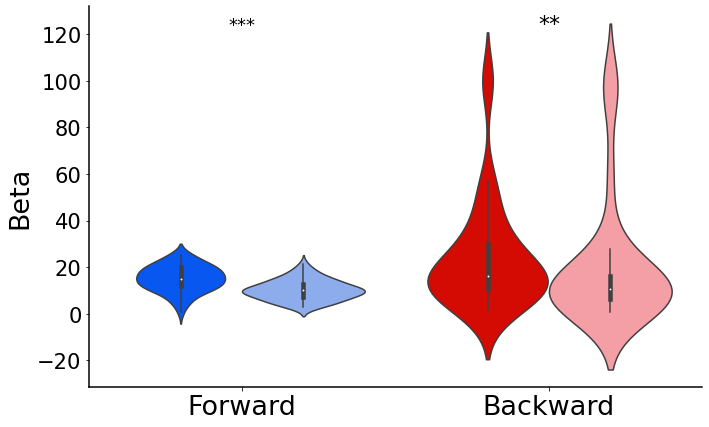

In [231]:
from seaborn import violinplot
from matplotlib.collections import PolyCollection

from matplotlib.legend_handler import HandlerTuple

fig, ax = plt.subplots(figsize=(11, 7))

colors = ["#0957F1", "#8DACEC", "#D40B02", "#F49EA5"]


ax = seaborn.violinplot(data=params_df, x="model", y="beta", hue = "task")

# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)
handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

# ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance", "High-Variance"], handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
#          , loc = "lower left")

ax.get_legend().remove()

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=27)
plt.yticks(fontsize=21)

ax.set_xticklabels(["Forward", "Backward"])

plt.ylabel("Beta", fontsize=27)
plt.xlabel("", fontsize=27)



gr1_data = forward_params_df.query("task=='{}'".format(gr1))
gr2_data = forward_params_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["beta"]), np.array(gr2_data["beta"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 0, 120,symb , ha='center', va='bottom', fontsize=18)

gr1_data = backward_params_df.query("task=='{}'".format(gr1))
gr2_data = backward_params_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["beta"]), np.array(gr2_data["beta"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 1, 120,symb , ha='center', va='bottom', fontsize=22)


plt.savefig("../figs/cross_task_perf_violin_beta.png", dpi=400, bbox_inches='tight')


plt.show()

Forward Low-var = 0.94
Forward High-var = 0.89
Statistics=288.0, p=0.04091907995939848
Backward Low-var = 0.66
Backward High-var = 0.63
Statistics=655.0, p=0.7568384093735303
Statistics=166.0, p=6.913045006177087e-07
Forward Low-var = 15.15
Forward High-var = 10.23
Statistics=420.0, p=0.008896865621109945
Backward Low-var = 24.13
Backward High-var = 20.68


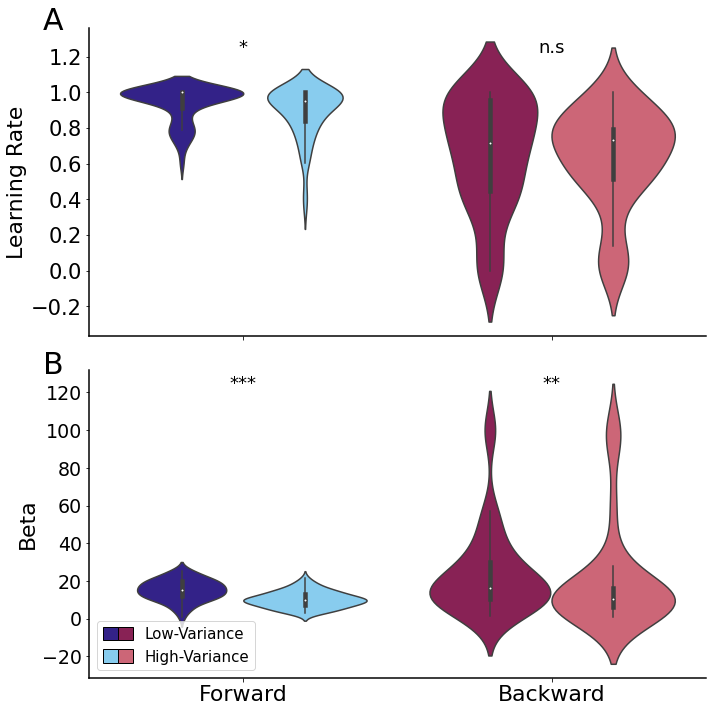

In [262]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(2,1,1)


from seaborn import violinplot
from matplotlib.collections import PolyCollection

from matplotlib.legend_handler import HandlerTuple

colors = [ "#332288", "#88CCEE", "#882255", "#CC6677"]


ax = seaborn.violinplot(data=params_df, x="model", y="alpha", hue = "task")

ax.text(-.65, 1.35, "A", fontsize=30)


# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)
handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

# ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance", "High-Variance"], handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
#          , loc = "lower left")

ax.get_legend().remove()

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=22)
plt.yticks(fontsize=21)

ax.set_xticklabels([])

plt.ylabel("Learning Rate", fontsize=22)
plt.xlabel("", fontsize=25)



gr1_data = forward_params_df.query("task=='{}'".format(gr1))
gr2_data = forward_params_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["alpha"]), np.array(gr2_data["alpha"]))

print("Forward Low-var = {:.2f}".format(gr1_data["alpha"].mean()))
print("Forward High-var = {:.2f}".format(gr2_data["alpha"].mean()))


print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 0, 1.2,symb , ha='center', va='bottom', fontsize=18)

gr1_data = backward_params_df.query("task=='{}'".format(gr1))
gr2_data = backward_params_df.query("task=='{}'".format(gr2))

print("Backward Low-var = {:.2f}".format(gr1_data["alpha"].mean()))
print("Backward High-var = {:.2f}".format(gr2_data["alpha"].mean()))


stat, p = scipy.stats.wilcoxon(np.array(gr1_data["alpha"]), np.array(gr2_data["alpha"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 1, 1.2,symb , ha='center', va='bottom', fontsize=18)


plt.subplot(2,1,2)


ax = seaborn.violinplot(data=params_df, x="model", y="beta", hue = "task")

ax.text(-.65, 130, "B", fontsize=30)


# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)
handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance", "High-Variance"], handlelength=2, handleheight=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "lower left")

ax.get_legend()

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=22)
plt.yticks(fontsize=19)

ax.set_xticklabels(["Forward", "Backward"])

plt.ylabel("Beta", fontsize=22)
plt.xlabel("", fontsize=22)



gr1_data = forward_params_df.query("task=='{}'".format(gr1))
gr2_data = forward_params_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["beta"]), np.array(gr2_data["beta"]))

print('Statistics={}, p={}'.format(stat, p))
print("Forward Low-var = {:.2f}".format(gr1_data["beta"].mean()))
print("Forward High-var = {:.2f}".format(gr2_data["beta"].mean()))

symb = pval_symb(p)

plt.text( 0, 120,symb , ha='center', va='bottom', fontsize=18)

gr1_data = backward_params_df.query("task=='{}'".format(gr1))
gr2_data = backward_params_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["beta"]), np.array(gr2_data["beta"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

print("Backward Low-var = {:.2f}".format(gr1_data["beta"].mean()))
print("Backward High-var = {:.2f}".format(gr2_data["beta"].mean()))

plt.text( 1, 120,symb , ha='center', va='bottom', fontsize=18)


plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig("../figs/cross_task_params.png", dpi=400, bbox_inches='tight')


Statistics=nan, p=nan


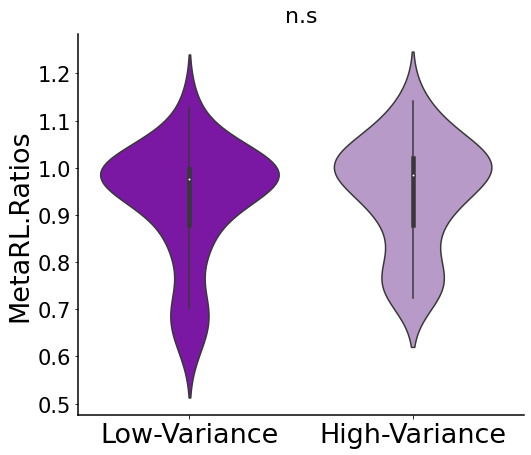

In [260]:
fig, ax = plt.subplots(figsize=(8, 7))

ax = seaborn.violinplot(data=mrl_df, x="model", y="mrl_ratio", palette= purple_pal)

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=27)
plt.yticks(fontsize=21)

ax.set_xticklabels(["Low-Variance", "High-Variance"])

plt.ylabel("MetaRL.Ratios", fontsize=27)
plt.xlabel("", fontsize=25)


gr1_data = mrl_df.query("model=='{}'".format(gr1))
gr2_data = mrl_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["mrl_ratio"]), np.array(gr2_data["mrl_ratio"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( .5, 1.3,symb , ha='center', va='bottom', fontsize=22)

plt.savefig("../figs/cross_task_metarl_violin.png", dpi=400, bbox_inches='tight')

plt.show()


Statistics=125.0, p=1.05588169887459e-07
Emprical Low-var = 0.86
Emprical High-var = 0.78
Statistics=57.0, p=3.5845890902721695e-09
Forward Low-var = 0.76
Forward High-var = 0.68
Statistics=207.0, p=4.011768559349753e-06
Backward Low-var = 0.71
Backward High-var = 0.64
Statistics=627.0, p=0.3199891506452244
MetRL Low-var = 0.93
MetRL High-var = 0.95
Empirical Low-var = 3.98
Empirical High-var = 3.79
Statistics=400.0, p=0.003188043227642762
Forward Low-var = 3.99
Forward High-var = 3.83
Statistics=443.0, p=0.009915556661071844
Backward Low-var = 3.99
Backward High-var = 3.80
Statistics=438.0, p=0.008746382294012317


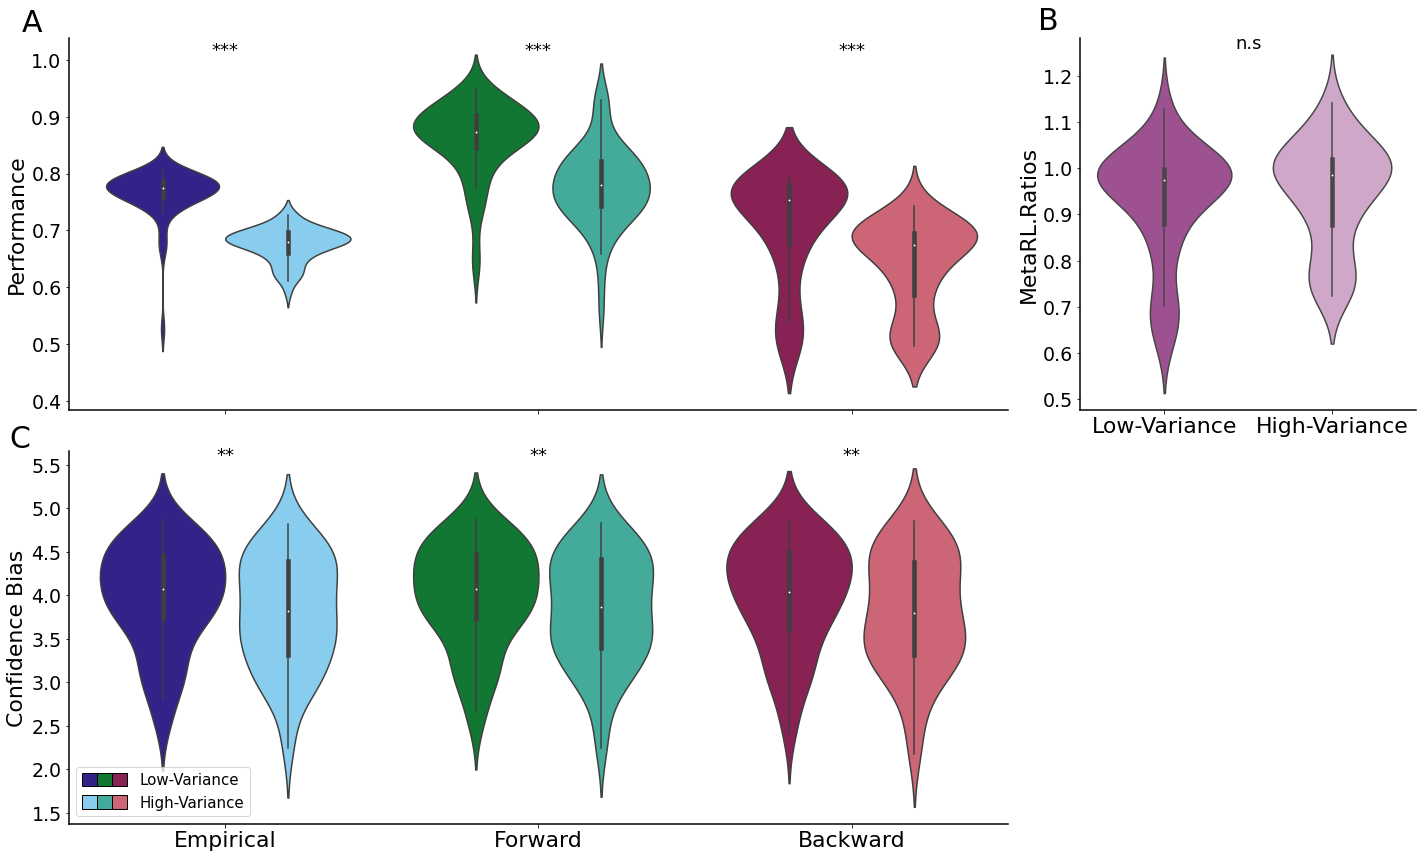

In [18]:
f, ((a0, a1), (a2, a3)) = plt.subplots(2, 2, gridspec_kw={'width_ratios': [2.8, 1]}, figsize=(20, 12))


from seaborn import violinplot
from matplotlib.collections import PolyCollection

from matplotlib.legend_handler import HandlerTuple

colors = [ "#332288", "#88CCEE", "#117733", "#44AA99", "#882255", "#CC6677"]

emp_df = df[["subject", "cor", "model"]]
emp_df = emp_df.rename(columns= {"model": "task", "cor": "Performance"})
emp_df["model"] = "Empirical"

fwd_df = df[["subject", "accuracy", "model"]]
fwd_df = fwd_df.rename(columns= {"model": "task", "accuracy": "Performance"})
fwd_df["model"] = "Forward"


bck_df = back_df[["subject", "accuracy", "model"]]
bck_df = bck_df.rename(columns= {"model": "task", "accuracy": "Performance"})
bck_df["model"] = "Backward"

violin_df = pd.concat([ fwd_df, emp_df, bck_df])


ax = seaborn.violinplot(data=violin_df, x="model", y="Performance", hue = "task", ax= a0)

# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)

handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

# ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance", "High-Variance"], handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
#          , loc = "lower left")

ax.get_legend().remove()


for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=19)

ax.set_xticklabels([])

ax.set_ylabel("Performance", fontsize=22)
ax.set_xlabel("", fontsize=27)


gr1_data = emp_df.query("task=='{}'".format(gr1))
gr2_data = emp_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["Performance"]), np.array(gr2_data["Performance"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

print("Emprical Low-var = {:.2f}".format(gr1_data["Performance"].mean()))
print("Emprical High-var = {:.2f}".format(gr2_data["Performance"].mean()))


ax.text( 1, 1.0,symb , ha='center', va='bottom', fontsize=18)

ax.text(-.65, 1.05, "A", fontsize=30)


gr1_data = fwd_df.query("task=='{}'".format(gr1))
gr2_data = fwd_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["Performance"]), np.array(gr2_data["Performance"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

print("Forward Low-var = {:.2f}".format(gr1_data["Performance"].mean()))
print("Forward High-var = {:.2f}".format(gr2_data["Performance"].mean()))


ax.text( 0, 1.0,symb , ha='center', va='bottom', fontsize=18)

gr1_data = bck_df.query("task=='{}'".format(gr1))
gr2_data = bck_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["Performance"]), np.array(gr2_data["Performance"]))


print('Statistics={}, p={}'.format(stat, p))

print("Backward Low-var = {:.2f}".format(gr1_data["Performance"].mean()))
print("Backward High-var = {:.2f}".format(gr2_data["Performance"].mean()))

symb = pval_symb(p)

ax.text( 2, 1.0,symb , ha='center', va='bottom', fontsize=18)

colors = ["#AA4499", "#D6A0CD"]


ax = seaborn.violinplot(data=mrl_df, x="model", y="mrl_ratio", palette= colors, ax = a1)

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=19)

ax.set_xticklabels(["Low-Variance", "High-Variance"])

ax.set_ylabel("MetaRL.Ratios", fontsize=22)
ax.set_xlabel("", fontsize=25)


gr1_data = mrl_df.query("model=='{}'".format(gr1))
gr2_data = mrl_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["mrl_ratio"]), np.array(gr2_data["mrl_ratio"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

print("MetRL Low-var = {:.2f}".format(gr1_data["mrl_ratio"].mean()))
print("MetRL High-var = {:.2f}".format(gr2_data["mrl_ratio"].mean()))

ax.text( .5, 1.25,symb , ha='center', va='bottom', fontsize=18)
ax.text(-.75, 1.3, "B", fontsize=30)


y_columns = "Conf"
colors = [ "#332288", "#88CCEE", "#117733", "#44AA99", "#882255", "#CC6677"]

emp_df = df[["subject", "cj", "model"]]
emp_df = emp_df.rename(columns= {"model": "task", "cj": y_columns})
emp_df["model"] = "Empirical"

fwd_df = df[["subject", "mean conf", "model"]]
fwd_df = fwd_df.rename(columns= {"model": "task", "mean conf": y_columns})
fwd_df["model"] = "Forward"


bck_df = back_df[["subject", "mean conf", "model"]]
bck_df = bck_df.rename(columns= {"model": "task", "mean conf": y_columns})
bck_df["model"] = "Backward"

violin_df = pd.concat([emp_df, fwd_df, bck_df])


ax = seaborn.violinplot(data=violin_df, x="model", y= y_columns, hue = "task" , ax = a2)

# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)
handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance", "High-Variance"], handlelength=3, handleheight=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "lower left")


for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=19)

ax.set_xticklabels(["Empirical", "Forward", "Backward"])

ax.set_ylabel("Confidence Bias", fontsize=22)
ax.set_xlabel("", fontsize=25)


gr1_data = emp_df.query("task=='{}'".format(gr1))
gr2_data = emp_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print("Empirical Low-var = {:.2f}".format(gr1_data[y_columns].mean()))
print("Empirical High-var = {:.2f}".format(gr2_data[y_columns].mean()))


print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

ax.text( 0, 5.5,symb , ha='center', va='bottom', fontsize=18)

gr1_data = fwd_df.query("task=='{}'".format(gr1))
gr2_data = fwd_df.query("task=='{}'".format(gr2))

print("Forward Low-var = {:.2f}".format(gr1_data[y_columns].mean()))
print("Forward High-var = {:.2f}".format(gr2_data[y_columns].mean()))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

ax.text( 1, 5.5,symb , ha='center', va='bottom', fontsize=18)

gr1_data = bck_df.query("task=='{}'".format(gr1))
gr2_data = bck_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print("Backward Low-var = {:.2f}".format(gr1_data[y_columns].mean()))
print("Backward High-var = {:.2f}".format(gr2_data[y_columns].mean()))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

ax.text( 2, 5.5,symb , ha='center', va='bottom', fontsize=18)
ax.text(-.69, 5.7, "C", fontsize=30)



a3.axis("off")

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/cross_task_compare.png", dpi=400, bbox_inches='tight')

# plt.show()

In [238]:
emp_df

,subject,Conf,task,model
0,45628,4.676476,lv_induction,Empirical
1,45640,4.494590,lv_induction,Empirical
2,45664,3.148277,lv_induction,Empirical
3,45682,3.741547,lv_induction,Empirical
4,45745,4.684585,lv_induction,Empirical
...,...,...,...,...
103,47431,4.016351,hv_induction,Empirical
104,47470,4.399357,hv_induction,Empirical
105,47737,2.750151,hv_induction,Empirical
106,47740,4.383498,hv_induction,Empirical


In [291]:
plots[]

<AxesSubplot:xlabel='model', ylabel='Performance'>

In [287]:
plots

<AxesSubplot:xlabel='model', ylabel='Performance'>

In [381]:
back_df

,subject,mean_reward,accuracy,mean conf,reward,cor,cj,fwd_emp,model,x_idx,conf_bias
0,45628,0.556979,0.785900,4.681623,0.589474,0.950000,4.676476,-0.164100,lv_induction,1,-0.030881
1,45640,0.501065,0.504700,4.502898,0.589456,0.940000,4.494590,-0.435300,lv_induction,2,-0.066352
2,45664,0.500449,0.499175,3.142602,0.556412,0.745000,3.148277,-0.245825,lv_induction,3,-0.207931
3,45682,0.532709,0.647775,4.015458,0.563513,0.825000,3.741547,-0.177225,lv_induction,4,-0.139613
4,45745,0.548403,0.739500,4.729891,0.588438,0.932500,4.684585,-0.193000,lv_induction,5,-0.011354
...,...,...,...,...,...,...,...,...,...,...,...
103,47431,0.532441,0.659774,3.855789,0.554269,0.746867,4.016351,-0.087093,hv_induction,250,0.007221
104,47470,0.525692,0.641078,4.550918,0.559196,0.804511,4.399357,-0.163434,hv_induction,251,0.045328
105,47737,0.528751,0.642782,2.612197,0.551392,0.739348,2.750151,-0.096566,hv_induction,252,-0.301811
106,47740,0.543346,0.718997,4.401691,0.557382,0.789474,4.383498,-0.070476,hv_induction,253,0.056401


In [384]:
groups = ['lv_induction', 'hv_induction']

In [388]:
back_df

,subject,mean_reward,accuracy,mean conf,reward,cor,cj,fwd_emp,model,x_idx,conf_bias
0,45628,0.556979,0.785900,4.681623,0.589474,0.950000,4.676476,-0.164100,lv_induction,1,-0.030881
1,45640,0.501065,0.504700,4.502898,0.589456,0.940000,4.494590,-0.435300,lv_induction,2,-0.066352
2,45664,0.500449,0.499175,3.142602,0.556412,0.745000,3.148277,-0.245825,lv_induction,3,-0.207931
3,45682,0.532709,0.647775,4.015458,0.563513,0.825000,3.741547,-0.177225,lv_induction,4,-0.139613
4,45745,0.548403,0.739500,4.729891,0.588438,0.932500,4.684585,-0.193000,lv_induction,5,-0.011354
...,...,...,...,...,...,...,...,...,...,...,...
103,47431,0.532441,0.659774,3.855789,0.554269,0.746867,4.016351,-0.087093,hv_induction,250,0.007221
104,47470,0.525692,0.641078,4.550918,0.559196,0.804511,4.399357,-0.163434,hv_induction,251,0.045328
105,47737,0.528751,0.642782,2.612197,0.551392,0.739348,2.750151,-0.096566,hv_induction,252,-0.301811
106,47740,0.543346,0.718997,4.401691,0.557382,0.789474,4.383498,-0.070476,hv_induction,253,0.056401


Statistics=619.0, p=0.2876178536082771
0.021742576832412513
0.02466739403888913


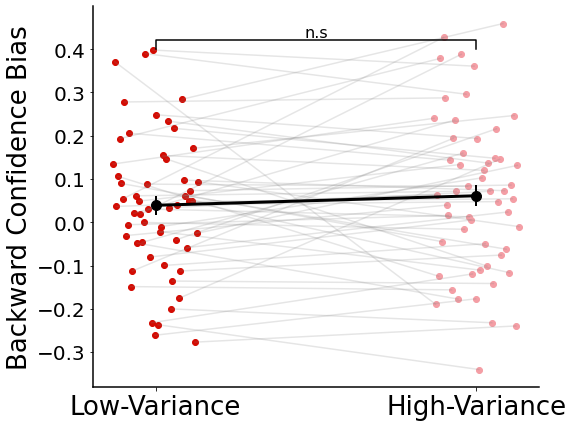

In [396]:
back_df["conf_bias"] = linear_transform_on_array(back_df["mean conf"], [1,5], [0,1]) - back_df["accuracy"]

plt.figure(figsize=(8, 7))

color_dict["lv_induction"] = "#D40B02" 
color_dict["hv_induction"] = "#F49EA5"

comparison_plot(
    back_df,
    "conf_bias",
    groups,
    "",
    [["lv_induction", "hv_induction"]],
    [.4],
    [0.02],
    y_label="Backward Confidence Bias",
    legend="lower right",
)

plt.savefig("../figs/cross_task_conf_bias_back_compare.png", dpi=400, bbox_inches='tight')


(p = 4.86e-09, r = 0.70, ci = [0.53,0.81])


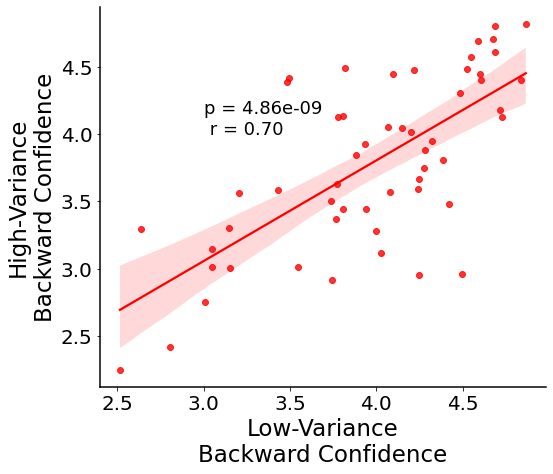

In [434]:
plt.figure(figsize=(8, 7))
back_df_lv = back_df[back_df["model"] == "lv_induction"]
back_df_hv = back_df[back_df["model"] == "hv_induction"]


res = scipy.stats.pearsonr(back_df_lv["cj"], back_df_hv["cj"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(x=back_df_lv["cj"], y=back_df_hv["cj"], color="red")

plt.ylabel("High-Variance\nBackward Confidence", fontsize=23)
plt.xlabel("Low-Variance\nBackward Confidence", fontsize=23)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(3, 4, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/cross_task_avg_conf_corr.png", dpi=400, bbox_inches='tight')


plt.show()

(p = 7.01e-06, r = 0.57, ci = [0.36,0.73])


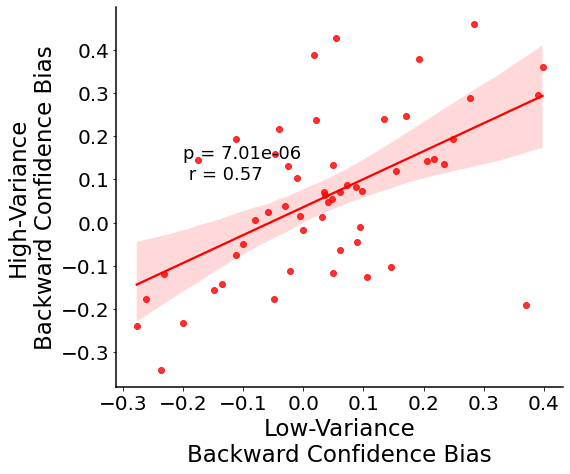

In [480]:
plt.figure(figsize=(8, 7))

back_df_lv = back_df[back_df["model"] == "lv_induction"]
back_df_hv = back_df[back_df["model"] == "hv_induction"]


res = scipy.stats.pearsonr(back_df_lv["conf_bias"], back_df_hv["conf_bias"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(x=back_df_lv["conf_bias"], y=back_df_hv["conf_bias"], color="red")

plt.ylabel("High-Variance\nBackward Confidence Bias", fontsize=23)
plt.xlabel("Low-Variance\nBackward Confidence Bias", fontsize=23)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(-.2, .1, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

# plt.savefig("../figs/cross_task_back_conf_bias_corr.png", dpi=400, bbox_inches='tight')


plt.show()

In [481]:
stat

0.5694196695302497

Statistics=411.0, p=0.004313350898602614
0.022320804569347662
0.022206807163420092


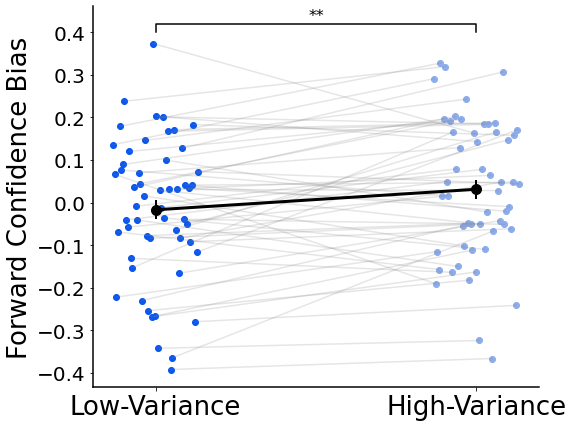

In [399]:
fwd_conf_df = df.copy()

fwd_conf_df["conf_bias"] = linear_transform_on_array(fwd_conf_df["mean conf"], [1,5], [0,1]) - fwd_conf_df["accuracy"]
plt.figure(figsize=(8, 7))

color_dict["lv_induction"] = "#0957F1" 
color_dict["hv_induction"] = "#8DACEC"

comparison_plot(
    fwd_conf_df,
    "conf_bias",
    groups,
    "",
    [["lv_induction", "hv_induction"]],
    [.4],
    [0.02],
    y_label="Forward Confidence Bias",
    legend="lower right",
)

# plt.savefig("../figs/cross_task_conf_bias_back_compare.png", dpi=400, bbox_inches='tight')


(p = 1.79e-10, r = 0.74, ci = [0.59,0.84])


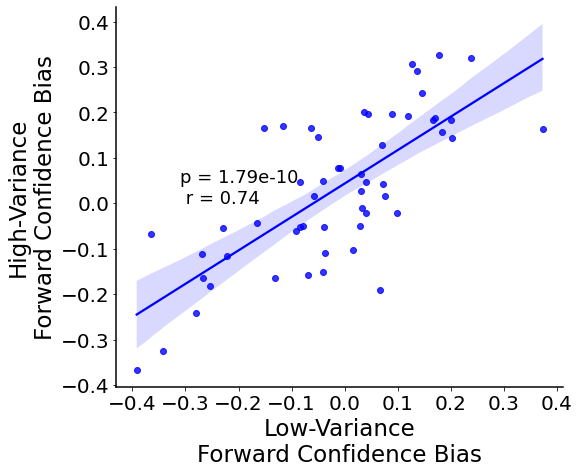

In [453]:
plt.figure(figsize=(8, 7))


fwd_df_lv = fwd_conf_df[fwd_conf_df["model"] == "lv_induction"]
fwd_df_hv = fwd_conf_df[fwd_conf_df["model"] == "hv_induction"]


res = scipy.stats.pearsonr(fwd_df_lv["conf_bias"], fwd_df_hv["conf_bias"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(x=fwd_df_lv["conf_bias"], y=fwd_df_hv["conf_bias"], color="blue")

plt.ylabel("High-Variance\nForward Confidence Bias", fontsize=23)
plt.xlabel("Low-Variance\nForward Confidence Bias", fontsize=23)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(-.31, 0, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/cross_task_fwd_conf_bias_corr.png", dpi=400, bbox_inches='tight')


plt.show()

In [454]:
fwd_conf_df

,subject,mean_reward,accuracy,mean conf,reward,cor,cj,fwd_emp,model,x_idx,conf_bias
0,45628,0.556151,0.784450,4.680266,0.589474,0.950000,4.676476,-0.165550,lv_induction,1,0.135616
1,45640,0.562015,0.808100,4.496108,0.589456,0.940000,4.494590,-0.131900,lv_induction,2,0.065927
2,45664,0.554719,0.759200,3.148277,0.556412,0.745000,3.148277,0.014200,lv_induction,3,-0.222131
3,45682,0.552194,0.754600,3.741676,0.563513,0.825000,3.741547,-0.070400,lv_induction,4,-0.069181
4,45745,0.552279,0.760000,4.754644,0.588438,0.932500,4.684585,-0.172500,lv_induction,5,0.178661
...,...,...,...,...,...,...,...,...,...,...,...
103,47431,0.545665,0.725714,4.093282,0.554269,0.746867,4.016351,-0.021153,hv_induction,250,0.047606
104,47470,0.537328,0.698195,4.423633,0.559196,0.804511,4.399357,-0.106316,hv_induction,251,0.157713
105,47737,0.537737,0.680426,2.755930,0.551392,0.739348,2.750151,-0.058922,hv_induction,252,-0.241443
106,47740,0.532932,0.677368,4.392121,0.557382,0.789474,4.383498,-0.112105,hv_induction,253,0.170662


In [ ]:
plt.figure(figsize=(8, 7))


fwd_df_lv = fwd_conf_df[fwd_conf_df["model"] == "lv_induction"]
fwd_df_hv = fwd_conf_df[fwd_conf_df["model"] == "hv_induction"]


res = scipy.stats.pearsonr(fwd_df_lv["conf_bias"], fwd_df_hv["conf_bias"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(x=fwd_df_lv["conf_bias"], y=fwd_df_hv["conf_bias"], color="blue")

plt.ylabel("High-Variance\nForward Confidence Bias", fontsize=23)
plt.xlabel("Low-Variance\nForward Confidence Bias", fontsize=23)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(-.31, 0, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/cross_task_fwd_conf_bias_corr.png", dpi=400, bbox_inches='tight')


plt.show()

(p = 1.15e-08, r = 0.68, ci = [0.51,0.80])
(p = 7.01e-06, r = 0.57, ci = [0.36,0.73])
(p = 1.79e-10, r = 0.74, ci = [0.59,0.84])


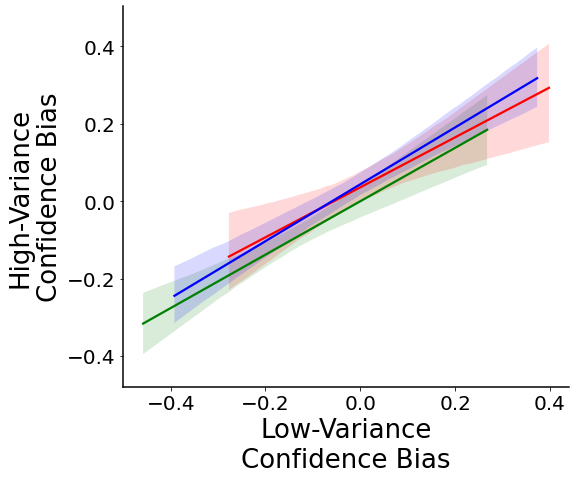

In [404]:
plt.figure(figsize=(8, 7))
avg_emp_conf_lv = avg_emp_conf[avg_emp_conf["model"] == "lv_induction"]
avg_emp_conf_hv = avg_emp_conf[avg_emp_conf["model"] == "hv_induction"]


res = scipy.stats.pearsonr(avg_emp_conf_lv["conf_bias"], avg_emp_conf_hv["conf_bias"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(x=avg_emp_conf_lv["conf_bias"], y=avg_emp_conf_hv["conf_bias"], color="green", scatter_kws={"alpha": 0})


back_df_lv = back_df[back_df["model"] == "lv_induction"]
back_df_hv = back_df[back_df["model"] == "hv_induction"]


res = scipy.stats.pearsonr(back_df_lv["conf_bias"], back_df_hv["conf_bias"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(x=back_df_lv["conf_bias"], y=back_df_hv["conf_bias"], color="red", scatter_kws={"alpha": 0})

fwd_df_lv = fwd_conf_df[fwd_conf_df["model"] == "lv_induction"]
fwd_df_hv = fwd_conf_df[fwd_conf_df["model"] == "hv_induction"]


res = scipy.stats.pearsonr(fwd_df_lv["conf_bias"], fwd_df_hv["conf_bias"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(x=fwd_df_lv["conf_bias"], y=fwd_df_hv["conf_bias"], color="blue", scatter_kws={"alpha": 0})


plt.ylabel("High-Variance\nConfidence Bias", fontsize=26)
plt.xlabel("Low-Variance\nConfidence Bias", fontsize=26)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.show()


Statistics=125.0, p=1.05588169887459e-07
0.008951572326293917
0.009636419618247636
Statistics=57.0, p=3.5845890902721695e-09
0.005897815745059614
0.004025794706339684
Statistics=207.0, p=4.011768559349753e-06
0.01287734906619939
0.010637241696025136
Statistics=627.0, p=0.3199891506452244
0.01686707657357483
0.01570680972515087


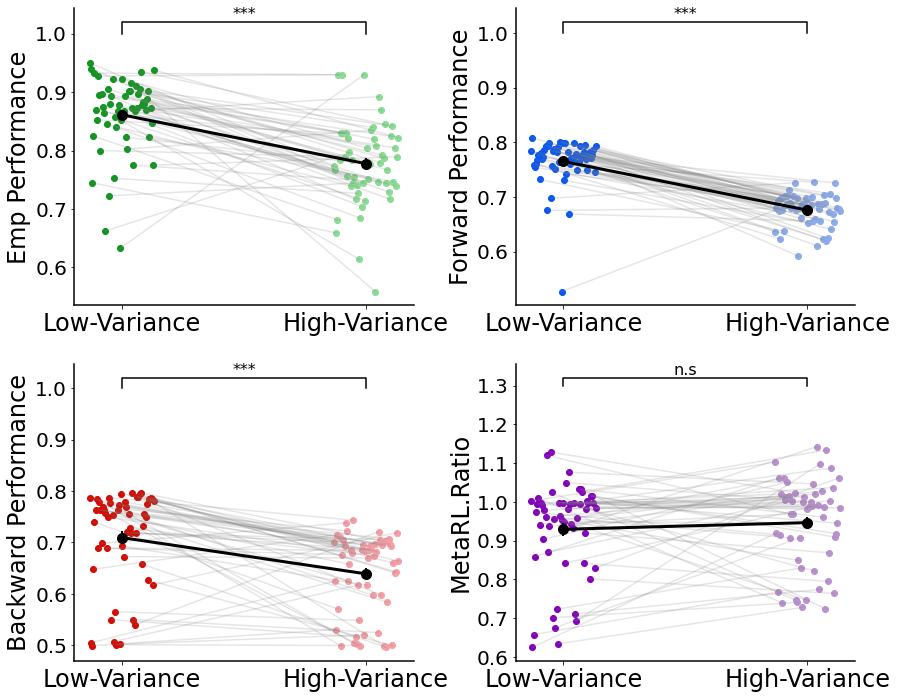

In [193]:
groups = ["lv_induction", "hv_induction"]

plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
color_dict["lv_induction"] = "#0E961E" 
color_dict["hv_induction"] = "#8ADC94"
comparison_plot(
    df,
    "cor",
    groups,
    "",
    [["lv_induction", "hv_induction"]],
    [1],
    [0.02],
    y_label="Emp Performance",
    legend="lower right",
)

plt.subplot(2, 2, 2)

color_dict["lv_induction"] = "#0957F1" 
color_dict["hv_induction"] = "#8DACEC"

comparison_plot(
    df,
    "accuracy",
    groups,
    "",
    [["lv_induction", "hv_induction"]],
    [1],
    [.02],
    y_label="Forward Performance",
    legend="lower right",
)


plt.subplot(2, 2, 3)

color_dict["lv_induction"] = "#D40B02" 
color_dict["hv_induction"] = "#F49EA5"


comparison_plot(
    back_df,
    "accuracy",
    groups,
    "",
    [["lv_induction", "hv_induction"]],
    [1],
    [0.02],
    y_label="Backward Performance",
    legend="lower right",
)

plt.subplot(2, 2, 4)

color_dict["lv_induction"] = "#8301BB" 
color_dict["hv_induction"] = "#BA92D0"


comparison_plot(
    mrl_df,
    "mrl_ratio",
    groups,
    "",
    [["lv_induction", "hv_induction"]],
    [1.3],
    [.02],
    y_label="MetaRL.Ratio",
    legend="lower right",
)

plt.subplots_adjust(
                    wspace=0.3,
                    hspace=0.2)
plt.savefig("../figs/Cross_task_perfs_compare.png", dpi=400, bbox_inches='tight')


Statistics=627.0, p=0.3199891506452244
0.01686707657357483
0.01570680972515087


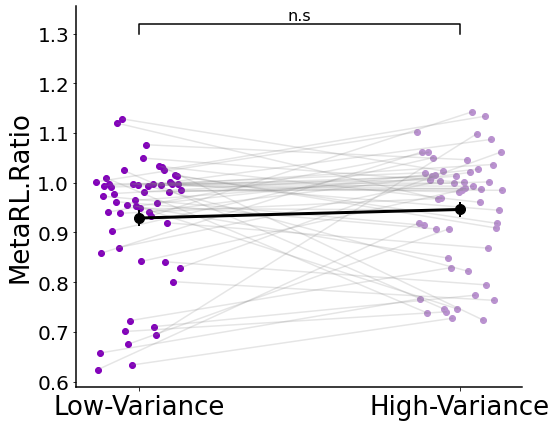

In [219]:
plt.figure(figsize=(8, 7))

color_dict["lv_induction"] = "#8301BB" 
color_dict["hv_induction"] = "#BA92D0"

comparison_plot(
    mrl_df,
    "mrl_ratio",
    groups,
    "",
    [["lv_induction", "hv_induction"]],
    [1.3],
    [.02],
    y_label="MetaRL.Ratio",
    legend="lower right",
)
plt.savefig("../figs/Cross_task_MetaRl_compare.png", dpi=400, bbox_inches='tight')


In [129]:
print(",".join([str(a) for a in df[df["model"] == "lv_induction"]["accuracy"]]))
print(",".join([str(a) for a in df[df["model"] == "hv_induction"]["accuracy"]]))

0.78445,0.8081,0.7592,0.7546,0.76,0.7675,0.7768,0.73215,0.781125,0.7693,0.772575,0.78565,0.7935,0.675275,0.7922,0.798,0.69735,0.757075,0.784025,0.787475,0.7507,0.782,0.791025,0.76415,0.8005,0.5269,0.797925,0.730175,0.7987,0.742225,0.782375,0.668675,0.7595,0.772,0.76975,0.797875,0.773925,0.77875,0.74895,0.763475,0.79265,0.7703,0.776,0.78185,0.795375,0.7698,0.749325,0.776975,0.7821,0.771875,0.7762,0.786025,0.74525,0.79275
0.6364661654135338,0.6798245614035088,0.6918045112781955,0.6735087719298246,0.623483709273183,0.6973182957393483,0.6751629072681704,0.6372932330827068,0.7014786967418546,0.6847117794486216,0.7024310776942356,0.7117543859649123,0.6892481203007519,0.6796992481203008,0.6823308270676691,0.7023558897243107,0.7259398496240601,0.6756892230576441,0.6977443609022557,0.5916791979949875,0.6800250626566416,0.6610526315789473,0.6866165413533835,0.6851378446115288,0.6861152882205513,0.6971177944862156,0.6969423558897243,0.6527568922305764,0.6794987468671679,0.6845614035087719,0.70015

In [130]:
print(",".join([str(a) for a in mrl_df[mrl_df["model"] == "lv_induction"]["mrl_ratio"]]))
print(",".join([str(a) for a in mrl_df[mrl_df["model"] == "hv_induction"]["mrl_ratio"]]))

1.0018484288354899,0.6245514169038485,0.6575013171759747,0.8584349324145242,0.9730263157894737,0.9943973941368078,1.009783728115345,0.9407225295362972,0.9976956313010082,0.9913882750552451,0.9034721548069766,0.9783300451855153,0.9620667926906112,1.1198030432046204,0.8697929815703106,0.9385651629072681,1.1284505628450563,1.0247993923983754,0.7009980549089634,0.9557446268135495,0.6755361662448381,0.7228260869565217,0.6334502702190197,0.9975462932670288,0.9645221736414741,0.9528847978743595,0.9962089168781528,0.9483685417879275,0.8418367346938775,1.049580652767018,0.9819779517494808,1.0764197853964932,0.9937129690585912,0.942130829015544,0.9331601169210783,0.997618674604418,0.7107600865716962,0.6929373996789727,0.9584751986113893,1.033268934804676,0.9951744149372359,1.031903154615085,1.0262886597938143,0.8411140244292383,0.9195976740531195,0.9815211743309951,1.0010009008107297,0.9976189710093633,0.8011443549418232,1.0156761133603238,1.0140427724813192,0.997169301230877,0.8285139215028515,

In [ ]:
print(",".join([str(a) for a in back_df[back_df["model"] == "lv_induction"]["accuracy"]]))
print(",".join([str(a) for a in back_df[back_df["model"] == "hv_induction"]["accuracy"]]))

In [217]:
groups = ["lv_induction", "hv_induction", "lv_test", "hv_test"]
forward_params_df = merge_result_df(forward_dfs, groups, 200, subjects)
backward_params_df = merge_result_df(backward_dfs, groups, 200, subjects)

Statistics=288.0, p=0.04091907995939848
Statistics=166.0, p=6.913045006177087e-07
Statistics=655.0, p=0.7568384093735303
Statistics=420.0, p=0.008896865621109945


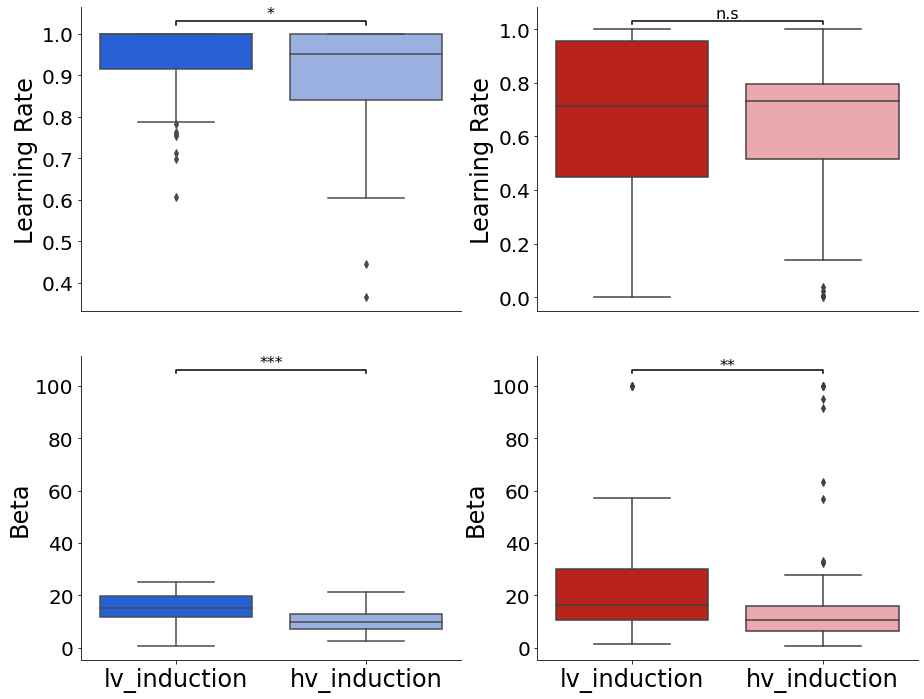

In [218]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)

green_pal = ["#0E961E", "#8ADC94"]
blue_pal = ["#0957F1", "#8DACEC"]
red_pal = ["#D40B02", "#F49EA5"]
purple_pal = ["#8301BB", "#BA92D0"]

y_column = "alpha"


gr1_data = forward_params_df.query("model=='{}'".format(gr1))
gr2_data = forward_params_df.query("model=='{}'".format(gr2))

seaborn.boxplot(data=forward_params_df, x= "model", y=y_column, palette = blue_pal)

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)


plt.plot([0,0, 1,1], [1.02,1.03, 1.03,1.02], lw=1.5, c="k")
plt.text(.5, 1.03, symb, ha='center', va='bottom', fontsize=16)
        

plt.title("", fontsize=12)
plt.ylabel("Learning Rate", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks([])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("")

plt.subplot(2, 2, 3)


y_column = "beta"
seaborn.boxplot(data=forward_params_df, x= "model", y=y_column, palette = blue_pal)

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.plot([0,0, 1,1], [105,106, 106,105], lw=1.5, c="k")
plt.text(.5, 106, symb, ha='center', va='bottom', fontsize=16)
        

plt.title("", fontsize=12)
plt.ylabel("Beta", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("")


plt.subplot(2, 2, 2)

y_column = "alpha"

seaborn.boxplot(data=backward_params_df, x= "model", y=y_column, palette = red_pal)

gr1_data = backward_params_df.query("model=='{}'".format(gr1))
gr2_data = backward_params_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))


print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.plot([0,0, 1,1], [1.02,1.03, 1.03,1.02], lw=1.5, c="k")
plt.text(.5, 1.03, symb, ha='center', va='bottom', fontsize=16)
        

plt.title("", fontsize=12)
plt.ylabel("Learning Rate", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks([])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("")

plt.subplot(2, 2, 4)

y_column = "beta"

seaborn.boxplot(data=backward_params_df, x= "model", y=y_column, palette = red_pal)

# gr1_data = mrl_df.query("model=='{}'".format(gr1))
# gr2_data = mrl_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))


print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.plot([0,0, 1,1], [105,106, 106,105], lw=1.5, c="k")
plt.text(.5, 105, symb, ha='center', va='bottom', fontsize=16)
        

plt.title("", fontsize=12)
plt.ylabel("Beta", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax = plt.gca()
plt.xlabel("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.subplots_adjust(
                    wspace=0.2,
                    hspace=0.15)

plt.show()

In [68]:
print(",".join([str(a) for a in forward_params_df[forward_params_df["model"] == "lv_induction"]["beta"]]))
print(",".join([str(a) for a in forward_params_df[forward_params_df["model"] == "hv_induction"]["beta"]]))

In [135]:
print(",".join([str(a) for a in backward_params_df[backward_params_df["model"] == "lv_induction"]["beta"]]))
print(",".join([str(a) for a in backward_params_df[backward_params_df["model"] == "hv_induction"]["beta"]]))

13.258571500778913,100.0,100.0,57.05839059097493,7.87681501778508,23.764483915971876,11.528015487836434,5.26188649247519,14.589949237299301,29.94611431694282,54.67855051599962,10.488980310440196,16.7569131191204,10.597286847453033,5.9778825535581595,8.780038113477874,13.00722061007709,16.960651157747336,1.2465552232354822,7.431507476099694,53.66262207793655,1.5865079627467893,30.172330999219714,15.118489406675002,18.51243608886573,16.397410942760885,14.774355090245834,29.65763414011521,8.431354221029869,17.044338460686838,10.079241750876518,6.824356320886016,9.554587507400754,10.995725387190882,36.746170320961774,15.599001002536722,1.2624931948512328,11.497111650263728,34.97510237514181,29.502354325783624,21.263683461091645,32.27333517703946,15.917903484835682,41.40081825876925,43.80236371756034,19.57841453814905,16.4999252852466,25.024163090537172,100.0,15.338459661311157,16.490635775346597,11.998194698885401,4.685639637738125,24.086625172138977
7.022549493742538,4.682959631671186,100

In [136]:
temp_df = backward_dfs[0].merge(backward_dfs[1], on = "subject")
temp_df

,subject,alpha_x,beta_x,lbound_x,bound_range_x,LL_x,Confidence Distance_x,hbound_x,model_x,x_idx_x,alpha_y,beta_y,lbound_y,bound_range_y,LL_y,Confidence Distance_y,hbound_y,model_y,x_idx_y
0,45628.0,1.000000,13.258572,4.606818,0.221298,139.032113,0.774456,4.693829,lv_induction,1,0.906276,7.022549,4.354870,0.852449,258.760541,0.658185,4.904810,hv_induction,201
1,45640.0,0.003908,100.000000,3.968331,1.000000,275.681212,0.410537,5.000000,lv_induction,2,0.502067,4.682960,1.000000,0.727874,171.761447,0.543188,3.911494,hv_induction,202
2,45664.0,0.001108,100.000000,1.270128,1.000000,275.198526,1.536389,5.000000,lv_induction,3,0.140507,100.000000,3.034371,0.183369,558.641602,1.351084,3.394807,hv_induction,203
3,45682.0,0.658565,57.058391,2.026064,0.693936,453.480584,0.705934,4.089785,lv_induction,4,0.843640,10.855426,1.000000,0.699040,257.019800,1.154843,3.796161,hv_induction,204
4,45745.0,1.000000,7.876815,4.041896,1.000000,190.566010,0.437457,5.000000,lv_induction,5,0.676461,2.030419,4.566400,1.000000,252.868449,0.339763,5.000000,hv_induction,205
5,45760.0,0.747970,23.764484,1.000000,0.927304,82.892275,0.533329,4.709216,lv_induction,6,0.886023,8.026264,1.000000,0.852668,104.450679,0.486825,4.410670,hv_induction,206
6,45763.0,0.900032,11.528015,2.346942,0.937333,69.632262,0.950495,4.833740,lv_induction,7,0.757233,95.103612,3.433165,0.816665,1326.590868,1.537966,4.712745,hv_induction,207
7,45805.0,0.945874,5.261886,4.643276,1.000000,212.436587,0.245864,5.000000,lv_induction,8,1.000000,9.819743,4.682960,0.639134,275.954168,0.328092,4.885591,hv_induction,208
8,45829.0,1.000000,14.589949,1.331203,0.832861,112.315226,0.742902,4.386802,lv_induction,9,0.629840,12.557645,1.908261,0.807499,119.131505,0.701353,4.404838,hv_induction,209
9,45964.0,0.486703,29.946114,1.794286,0.765650,164.947370,0.772505,4.248742,lv_induction,10,0.425089,12.581678,1.392946,0.859077,142.080221,1.085085,4.491682,hv_induction,210


(p = 3.28e-07, r = 0.63, ci = [0.44,0.77])


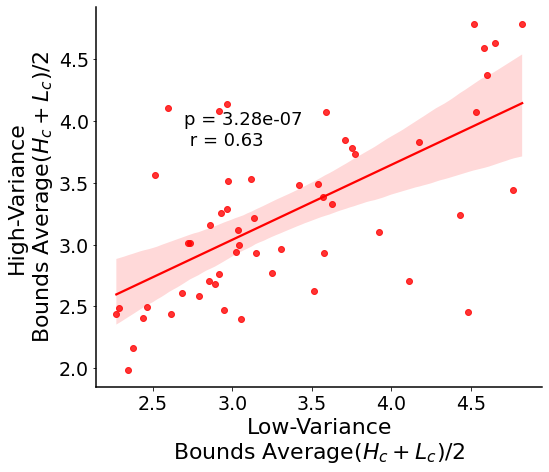

In [139]:

plt.figure(figsize=(8, 7))

temp_df = backward_dfs[0].merge(backward_dfs[1], on = "subject")
temp_df["scale_avg_lv"] = (temp_df["lbound_x"] + temp_df["hbound_x"])/2
temp_df["scale_avg_hv"] = (temp_df["lbound_y"] + temp_df["hbound_y"])/2


res = scipy.stats.pearsonr(temp_df["scale_avg_lv"], temp_df["scale_avg_hv"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))

seaborn.regplot(data=temp_df, x="scale_avg_lv", y="scale_avg_hv", color="red")

plt.ylabel("High-Variance\nBounds Average" + r"$(H_c + L_c)/2$", fontsize=22)
plt.xlabel("Low-Variance\nBounds Average" + r"$(H_c + L_c)/2$", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(2.7, 3.8, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/Cross_task_Bounds_correlation.png", dpi=400, bbox_inches='tight')


plt.show()

In [141]:
temp_df

,subject,mean_reward_x,accuracy_x,mean conf_x,reward_x,cor_x,cj_x,fwd_emp_x,model_x,x_idx_x,mean_reward_y,accuracy_y,mean conf_y,reward_y,cor_y,cj_y,fwd_emp_y,model_y,x_idx_y
0,45628,0.556151,0.784450,4.680266,0.589474,0.9500,4.676476,-0.165550,lv_induction,1,0.527667,0.636466,4.708327,0.560322,0.774436,4.707175,-0.137970,hv_induction,201
1,45640,0.562015,0.808100,4.496108,0.589456,0.9400,4.494590,-0.131900,lv_induction,2,0.533465,0.679825,2.958140,0.553542,0.766917,2.959315,-0.087093,hv_induction,202
2,45664,0.554719,0.759200,3.148277,0.556412,0.7450,3.148277,0.014200,lv_induction,3,0.540083,0.691805,3.306281,0.534510,0.659148,3.299199,0.032657,hv_induction,203
3,45682,0.552194,0.754600,3.741676,0.563513,0.8250,3.741547,-0.070400,lv_induction,4,0.535292,0.673509,3.065001,0.536143,0.681704,2.918609,-0.008195,hv_induction,204
4,45745,0.552279,0.760000,4.754644,0.588438,0.9325,4.684585,-0.172500,lv_induction,5,0.523165,0.623484,4.802583,0.590682,0.929825,4.800984,-0.306341,hv_induction,205
5,45760,0.554309,0.767500,4.375536,0.576588,0.8700,4.276919,-0.102500,lv_induction,6,0.539941,0.697318,3.853643,0.568228,0.784461,3.747070,-0.087143,hv_induction,206
6,45763,0.554923,0.776800,4.464513,0.571570,0.8525,4.526510,-0.075700,lv_induction,7,0.535940,0.675163,4.485184,0.565942,0.829574,4.483209,-0.154411,hv_induction,207
7,45805,0.546727,0.732150,4.879383,0.587205,0.9275,4.865320,-0.195350,lv_induction,8,0.526980,0.637293,4.824933,0.587924,0.929825,4.817304,-0.292531,hv_induction,208
8,45829,0.558874,0.781125,3.961497,0.579369,0.8950,3.932559,-0.113875,lv_induction,9,0.538649,0.701479,4.002642,0.568517,0.829574,3.922199,-0.128095,hv_induction,209
9,45964,0.554786,0.769300,3.845748,0.558664,0.8000,3.879826,-0.030700,lv_induction,10,0.535929,0.684712,3.803200,0.554262,0.789474,3.842183,-0.104762,hv_induction,210


(p = 4.86e-09, r = 0.70, ci = [0.53,0.81])


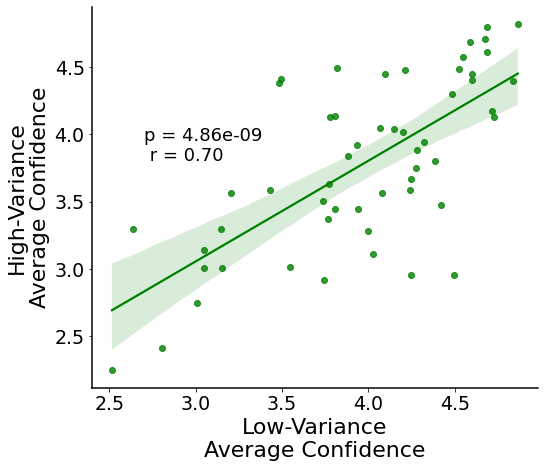

In [145]:

plt.figure(figsize=(8, 7))

temp_df = forward_avg_dfs[0].merge(forward_avg_dfs[1], on = "subject")

res = scipy.stats.pearsonr(temp_df["cj_x"], temp_df["cj_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(data=temp_df, x="cj_x", y="cj_y", color="green")

plt.ylabel("High-Variance\nAverage Confidence", fontsize=22)
plt.xlabel("Low-Variance\nAverage Confidence", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(2.7, 3.8, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/Cross_task_emp_avgconf.png", dpi=400, bbox_inches='tight')


plt.show()

In [43]:
params_df

,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound,model,x_idx,task
0,45628.0,1.000000,11.609160,4.605658,0.227874,137.997922,0.774465,4.695518,forward_lv_inuction,1,lv_inuction
1,45640.0,0.712177,16.827743,4.462571,0.071960,114.860509,0.418840,4.501244,forward_lv_inuction,2,lv_inuction
2,45664.0,1.000000,9.946770,3.148277,0.000000,164.286110,1.549730,3.148277,forward_lv_inuction,3,lv_inuction
3,45682.0,1.000000,10.014854,1.488940,0.821553,144.475233,0.728441,4.373464,forward_lv_inuction,4,lv_inuction
4,45745.0,1.000000,9.672207,4.092176,0.945758,188.692218,0.437737,4.950758,forward_lv_inuction,5,lv_inuction
...,...,...,...,...,...,...,...,...,...,...,...
211,47431.0,0.719021,4.520113,1.960070,1.000000,171.880035,0.622341,5.000000,backward_hv_inuction,650,hv_inuction
212,47470.0,1.000000,16.279409,2.176431,0.898570,112.036760,0.686963,4.713606,backward_hv_inuction,651,hv_inuction
213,47737.0,0.566020,4.811324,1.506758,0.515835,161.206712,0.905014,3.308693,backward_hv_inuction,652,hv_inuction
214,47740.0,0.597513,12.182257,2.163447,0.961255,113.127618,1.017667,4.890097,backward_hv_inuction,653,hv_inuction


In [44]:
forward_params_df

,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound,model,x_idx,task
0,45628.0,1.000000,11.609160,4.605658,0.227874,137.997922,0.774465,4.695518,forward_lv_inuction,1,lv_inuction
1,45640.0,0.712177,16.827743,4.462571,0.071960,114.860509,0.418840,4.501244,forward_lv_inuction,2,lv_inuction
2,45664.0,1.000000,9.946770,3.148277,0.000000,164.286110,1.549730,3.148277,forward_lv_inuction,3,lv_inuction
3,45682.0,1.000000,10.014854,1.488940,0.821553,144.475233,0.728441,4.373464,forward_lv_inuction,4,lv_inuction
4,45745.0,1.000000,9.672207,4.092176,0.945758,188.692218,0.437737,4.950758,forward_lv_inuction,5,lv_inuction
...,...,...,...,...,...,...,...,...,...,...,...
103,47431.0,0.858259,9.174509,2.505902,0.787838,144.606215,0.641299,4.470847,forward_hv_inuction,250,hv_inuction
104,47470.0,1.000000,10.259416,2.076380,0.936043,100.463251,0.697948,4.813015,forward_hv_inuction,251,hv_inuction
105,47737.0,0.958583,10.299954,1.855249,0.341381,110.271026,0.923049,2.928807,forward_hv_inuction,252,hv_inuction
106,47740.0,1.000000,11.068236,2.345203,0.886145,89.367163,1.110051,4.697737,forward_hv_inuction,253,hv_inuction


In [224]:
forward_params_df.loc[forward_params_df["model"] == "lv_induction", "model"] = "forward_lv_inuction"
forward_params_df.loc[forward_params_df["model"] == "hv_induction", "model"] = "forward_hv_inuction"

backward_params_df.loc[backward_params_df["model"] == "lv_induction", "model"] = "backward_lv_inuction"
backward_params_df.loc[backward_params_df["model"] == "hv_induction", "model"] = "backward_hv_inuction"

fwd_df_1 = forward_params_df.loc[forward_params_df["model"] == "forward_lv_inuction"]
fwd_df_2 = forward_params_df.loc[forward_params_df["model"] == "forward_hv_inuction"]
bck_df_1 = backward_params_df.loc[backward_params_df["model"] == "backward_lv_inuction"]
bck_df_2 = backward_params_df.loc[backward_params_df["model"] == "backward_hv_inuction"]

dataframes = [fwd_df_1, fwd_df_2, bck_df_1, bck_df_2]

subj_to_ind = {}
subj_to_ind_low = {}
idx = 1
gap = 200
for subject in subjects:
    subj_to_ind[subject] = idx
    idx += 1
count = 0
for df in dataframes:
    df["x_idx"] = df.apply(lambda x: subj_to_ind[x["subject"]] + count * gap, axis=1)
    count += 1

params_df = pd.concat(dataframes, ignore_index=True)





/tmp/ipykernel_24862/3261012406.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["x_idx"] = df.apply(lambda x: subj_to_ind[x["subject"]] + count * gap, axis=1)
/tmp/ipykernel_24862/3261012406.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["x_idx"] = df.apply(lambda x: subj_to_ind[x["subject"]] + count * gap, axis=1)
/tmp/ipykernel_24862/3261012406.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Statistics=288.0, p=0.04091907995939848
Statistics=189.0, p=2.5235927599199303e-05
Statistics=655.0, p=0.7568384093735303


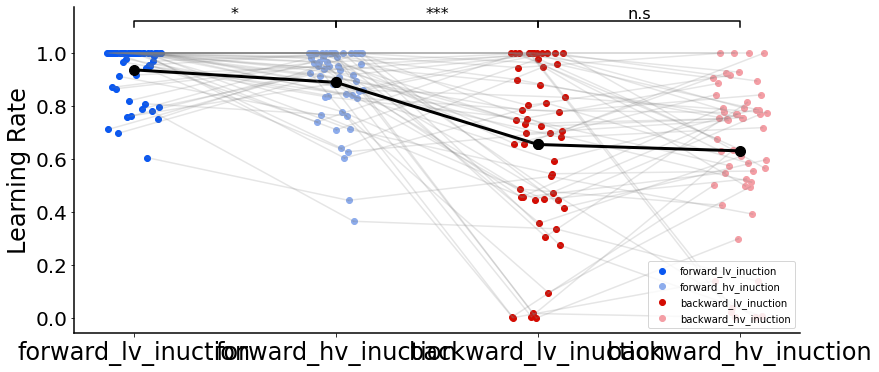

In [72]:
plt.figure(figsize=(13, 6))

color_dict["forward_lv_inuction"] = "#0957F1" 
color_dict["forward_hv_inuction"] = "#8DACEC"
color_dict["backward_lv_inuction"] = "#D40B02" 
color_dict["backward_hv_inuction"] = "#F49EA5"

comparison_plot(
    params_df,
    "alpha",
    ["forward_lv_inuction", "forward_hv_inuction", "backward_lv_inuction", "backward_hv_inuction"],
    "",
    [["forward_lv_inuction", "forward_hv_inuction"], ["forward_hv_inuction", "backward_lv_inuction"],
     ["backward_lv_inuction", "backward_hv_inuction"]],
    [1.1, 1.1, 1.1],
    [0.02, .02, .02],
    y_label="Learning Rate",
    legend="lower right",
)


Statistics=166.0, p=6.913045006177087e-07
Statistics=239.0, p=1.4559802620378717e-05
Statistics=423.0, p=0.009613394634938585


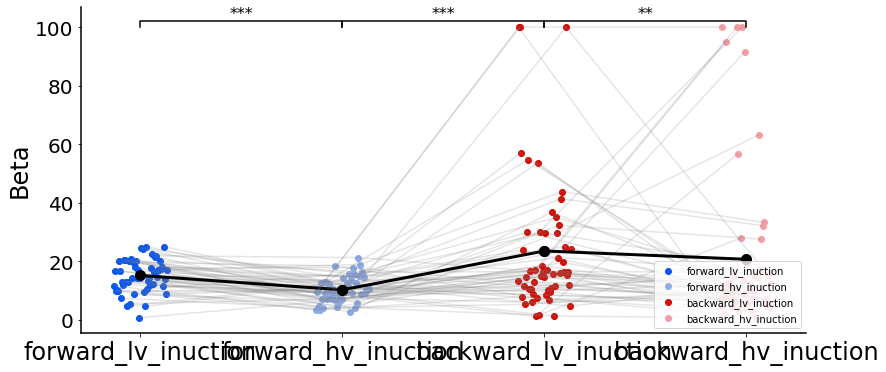

In [73]:
plt.figure(figsize=(13, 6))

comparison_plot(
    params_df,
    "beta",
    ["forward_lv_inuction", "forward_hv_inuction", "backward_lv_inuction", "backward_hv_inuction"],
    "",
    [["forward_lv_inuction", "forward_hv_inuction"], ["forward_hv_inuction", "backward_lv_inuction"],
     ["backward_lv_inuction", "backward_hv_inuction"]],
    [100, 100, 100],
    [2, 2, 2],
    y_label="Beta",
    legend="lower right",
)


Statistics=288.0, p=0.04091907995939848
Statistics=189.0, p=2.5235927599199303e-05


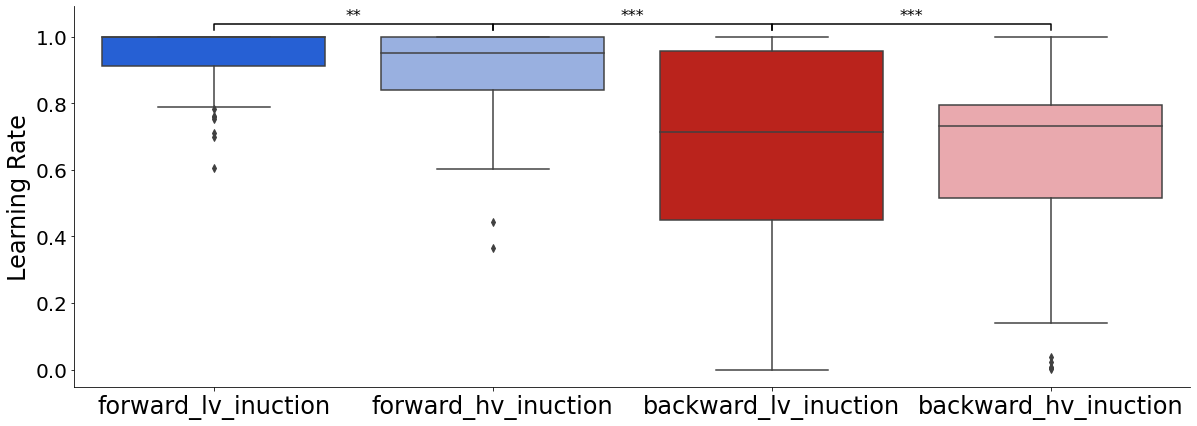

In [74]:
plt.figure(figsize=(20, 7))


mixed_pal = ["#0957F1", "#8DACEC", "#D40B02", "#F49EA5"]

y_column = "alpha"
seaborn.boxplot(data=params_df, x= "model", y=y_column, palette = mixed_pal)

plt.title("", fontsize=12)
plt.ylabel("Learning Rate", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("")

gr1 = "forward_lv_inuction"
gr2 = "forward_hv_inuction"
gr1_data = params_df.query("model=='{}'".format(gr1))
gr2_data = params_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))

plt.plot([0,0, 1,1], [1.02,1.04, 1.04,1.02], lw=1.5, c="k")
plt.text(.5, 1.04, symb, ha='center', va='bottom', fontsize=16)

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)


gr1 = "forward_hv_inuction"
gr2 = "backward_lv_inuction"
gr1_data = params_df.query("model=='{}'".format(gr1))
gr2_data = params_df.query("model=='{}'".format(gr2))


stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)


plt.plot([1,1, 2,2], [1.02,1.04, 1.04,1.02], lw=1.5, c="k")
plt.text(1.5, 1.04, symb, ha='center', va='bottom', fontsize=16)

gr1 = "backward_lv_inuction"
gr2 = "backward_hv_inuction"
gr1_data = params_df.query("model=='{}'".format(gr1))
gr2_data = params_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))

plt.plot([2,2, 3,3], [1.02,1.04, 1.04,1.02], lw=1.5, c="k")
plt.text(2.5, 1.04, symb, ha='center', va='bottom', fontsize=16)

plt.show()

Statistics=166.0, p=6.913045006177087e-07
Statistics=239.0, p=1.4559802620378717e-05
Statistics=423.0, p=0.009613394634938585


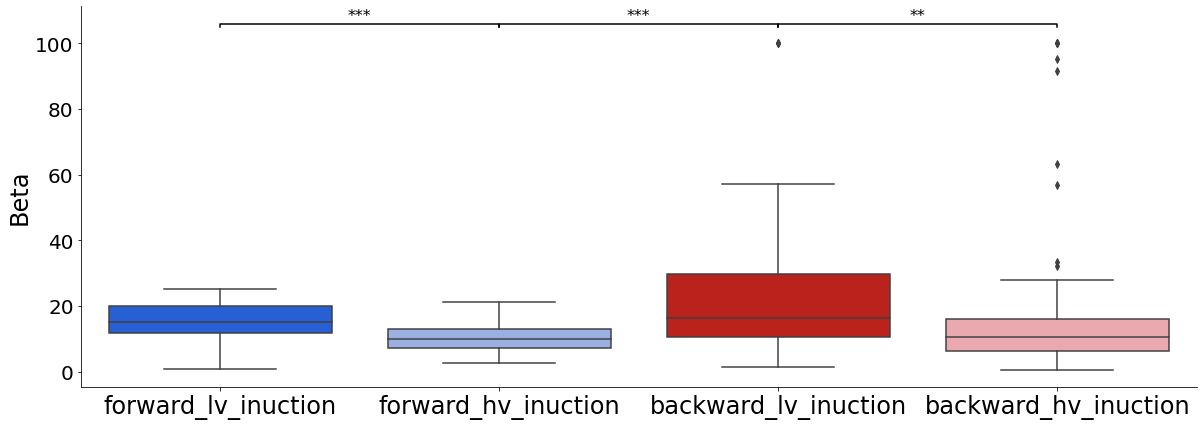

In [75]:
plt.figure(figsize=(20, 7))


mixed_pal = ["#0957F1", "#8DACEC", "#D40B02", "#F49EA5"]

y_column = "beta"
seaborn.boxplot(data=params_df, x= "model", y=y_column, palette = mixed_pal)

plt.title("", fontsize=12)
plt.ylabel("Beta", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("")

gr1 = "forward_lv_inuction"
gr2 = "forward_hv_inuction"
gr1_data = params_df.query("model=='{}'".format(gr1))
gr2_data = params_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))

plt.plot([0,0, 1,1], [105,106, 106,105], lw=1.5, c="k")
plt.text(.5, 106, symb, ha='center', va='bottom', fontsize=16)

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)


gr1 = "forward_hv_inuction"
gr2 = "backward_lv_inuction"
gr1_data = params_df.query("model=='{}'".format(gr1))
gr2_data = params_df.query("model=='{}'".format(gr2))


stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)


plt.plot([1,1, 2,2], [105,106, 106,105], lw=1.5, c="k")
plt.text(1.5, 106, symb, ha='center', va='bottom', fontsize=16)

gr1 = "backward_lv_inuction"
gr2 = "backward_hv_inuction"
gr1_data = params_df.query("model=='{}'".format(gr1))
gr2_data = params_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)


plt.plot([2,2, 3,3], [105,106, 106,105] , lw=1.5, c="k")
plt.text(2.5, 106, symb, ha='center', va='bottom', fontsize=16)

plt.show()

In [215]:
def comparison_plot(df, y_column, groups, titlestr="", s=[], y_list=[], h_list=[], legend="", y_label="",
                    var_df=pd.DataFrame()):
    

    for gr1, gr2 in zip(groups[:-1], groups[1:]):
        X_coords = np.array([df.query("model=='{}'".format(gr1)).x_idx,
                             df.query("model=='{}'".format(gr2)).x_idx])
        Y_coords = np.array([df.query("model=='{}'".format(gr1))[y_column],
                             df.query("model=='{}'".format(gr2))[y_column]])
        plt.plot(X_coords,
                 Y_coords,
                 color='gray',
                 alpha=.2)

        x_means = [df.query("model=='{}'".format(gr1)).x_idx.mean(), df.query("model=='{}'".format(gr2)).x_idx.mean()]
        y_means = [df.query("model=='{}'".format(gr1))[y_column].mean(),
                   df.query("model=='{}'".format(gr2))[y_column].mean()]
        plt.plot(x_means,
                 y_means,
                 marker='o',
                 linewidth=3, markersize=10, color="black")

    c = 0
    for gr1, gr2 in s:
        gr1_data = df.query("model=='{}'".format(gr1))
        gr2_data = df.query("model=='{}'".format(gr2))
        gr1_x_mean = gr1_data.x_idx.mean()
        gr2_x_mean = gr2_data.x_idx.mean()

        # stat, p = scipy.stats.ttest_ind(np.array(gr1_data[y_column]),np.array(gr2_data[y_column])).pvalue
        stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
        print('Statistics={}, p={}'.format(stat, p))
        symb = pval_symb(p)
        y = y_list[c]
        h = h_list[c]
        plt.plot([gr1_x_mean, gr1_x_mean, gr2_x_mean, gr2_x_mean], [y, y + h, y + h, y], lw=1.5, c="k")
        plt.text((gr1_x_mean + gr2_x_mean) / 2, y + h, symb, ha='center', va='bottom', fontsize=16)
        c += 1

    gr_xticks_ls = []
    for gr in groups:
        plt.scatter(df.query("model=='{}'".format(gr)).x_idx,
                    df.query("model=='{}'".format(gr))[y_column],
                    label=gr, c=color_dict[gr])
        gr_mean = df.query("model=='{}'".format(gr)).x_idx.mean()
        gr_y_mean =  df.query("model=='{}'".format(gr))[y_column].mean()
        gr_y_var =  scipy.stats.sem(df.query("model=='{}'".format(gr))[y_column])
        print(gr_y_var)
        plt.vlines(x=gr_mean, ymin=gr_y_mean, ymax=gr_y_mean + gr_y_var, colors="black", lw = 2)
        plt.vlines(x=gr_mean, ymin=gr_y_mean, ymax=gr_y_mean  - gr_y_var, colors="black", lw = 2)
        gr_xticks_ls.append(gr_mean)

    if not var_df.empty:
        for i, row in var_df.iterrows():
            line_pos = df[(df['subject'] == row["subject"]) & (df['model'] == row["model"])]["x_idx"].iloc[0]
            line_mean = df[(df['subject'] == row["subject"]) & (df['model'] == row["model"])][y_column].iloc[0]
            y_min = line_mean - row[y_column]
            y_max = line_mean + row[y_column]
            plt.vlines(x=line_pos, ymin=y_min, ymax=y_max, colors=color_dict[row["model"]], alpha=.4)
            plt.hlines(y=y_min, xmin=line_pos - 1, xmax=line_pos + 1, colors=color_dict[row["model"]], alpha=.5)
            plt.hlines(y=y_max, xmin=line_pos - 1, xmax=line_pos + 1, colors= color_dict[row["model"]], alpha=.5)

    plt.title(titlestr, fontsize=12)
    plt.ylabel(y_label, fontsize=26)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=26)
    ax = plt.gca()
#     plt.xticks(gr_xticks_ls, ["Low-Variance", "High-Variance", "Low-Variance", "High-Variance"])
    plt.xticks(gr_xticks_ls, ["Low-Variance", "High-Variance"])

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

    # hide x-axis
    # ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

#     if legend != "":
#         ax.legend(loc=legend)
#     else:
#         ax.legend()



In [77]:
color_dict = {"Forward" : "blue", "Backward": "red", "Empirical": "green", "Low-Meta": "#E6B0AA", "High-Meta": "#C60F28", 
              "Backward_perfomance": "red" ,"MetaRL.Ratio": "green", "lv_induction": "lime", "hv_induction": "darkgreen", "lv_test": "lightcoral", "hv_test": "darkred", "Noise_1":"red", "Noise_2": "#EE9EA9", "Noise_3": "#CD6155",
             "Forward_Noise_1": "#3A78EC", "Forward_Noise_2": "#94B4EE"}

In [81]:
forward_params_df

,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound,model,x_idx
0,45628.0,1.000000,11.609160,4.605658,0.227874,137.997922,0.774465,4.695518,forward_lv_inuction,1
1,45640.0,0.712177,16.827742,4.462571,0.071960,114.860509,0.418840,4.501244,forward_lv_inuction,2
2,45664.0,1.000000,9.946770,3.148277,0.000000,164.286110,1.549730,3.148277,forward_lv_inuction,3
3,45682.0,1.000000,10.014854,1.488940,0.821553,144.475233,0.728441,4.373464,forward_lv_inuction,4
4,45745.0,1.000000,9.672207,4.092176,0.945759,188.692218,0.437737,4.950758,forward_lv_inuction,5
...,...,...,...,...,...,...,...,...,...,...
103,47431.0,0.858259,9.174509,2.505902,0.787838,144.606215,0.641299,4.470847,forward_hv_inuction,250
104,47470.0,1.000000,10.259416,2.076380,0.936043,100.463251,0.697948,4.813015,forward_hv_inuction,251
105,47737.0,0.958583,10.299954,1.855249,0.341381,110.271026,0.923049,2.928807,forward_hv_inuction,252
106,47740.0,1.000000,11.068236,2.345203,0.886145,89.367163,1.110051,4.697737,forward_hv_inuction,253


Statistics=288.0, p=0.04091907995939848
0.013897522213561749
0.019746155279771173
Statistics=166.0, p=6.913045006177087e-07
0.7569531896482877
0.5847055253570701
Statistics=655.0, p=0.7568384093735303
0.04299408190557927
0.03791638973642692
Statistics=423.0, p=0.009613394634938585
3.1149289087307785
3.7201993570905096


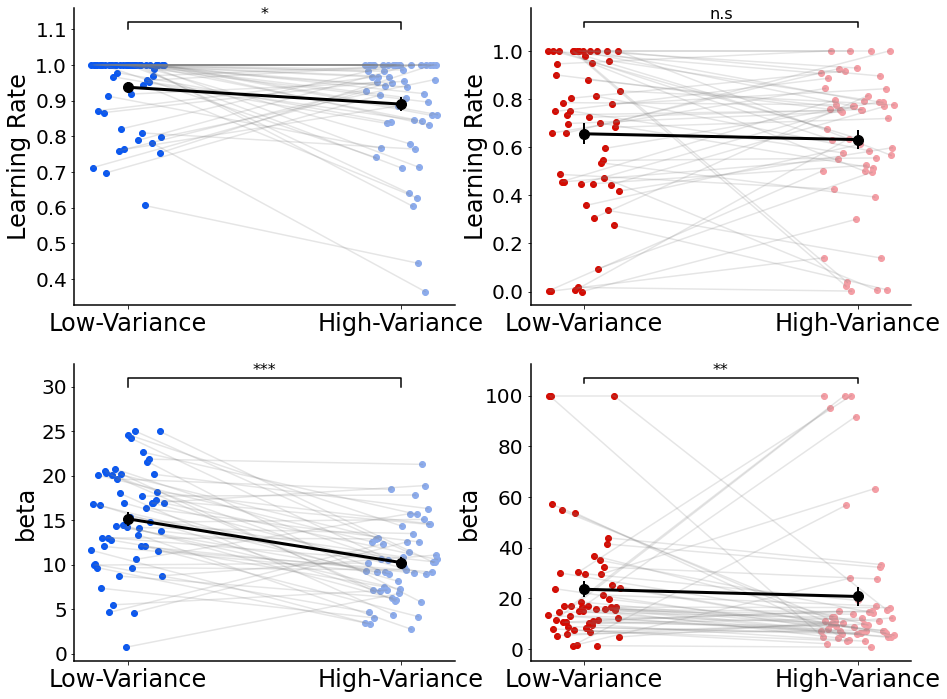

In [88]:
groups = ["lv_induction", "hv_induction"]

plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
color_dict["lv_induction"] = "#0957F1"
color_dict["hv_induction"] = "#8DACEC"
comparison_plot(
    forward_params_df,
    "alpha",
    groups,
    "",
    [["lv_induction", "hv_induction"]],
    [1.1],
    [0.02],
    y_label="Learning Rate",
    legend="lower right",
)

plt.subplot(2, 2, 3)

comparison_plot(
    forward_params_df,
    "beta",
    groups,
    "",
    [["lv_induction", "hv_induction"]],
    [30],
    [1],
    y_label="beta",
    legend="lower right",
)

color_dict["lv_induction"] = "#D40B02"
color_dict["hv_induction"] = "#F49EA5"

plt.subplot(2, 2, 2)

comparison_plot(
    backward_params_df,
    "alpha",
    groups,
    "",
    [["lv_induction", "hv_induction"]],
    [1.1],
    [0.02],
    y_label="Learning Rate",
    legend="lower right",
)

plt.subplot(2, 2, 4)

comparison_plot(
    backward_params_df,
    "beta",
    groups,
    "",
    [["lv_induction", "hv_induction"]],
    [105],
    [2],
    y_label="beta",
    legend="lower right",
)

plt.savefig("../figs/Cross_task_params_compare.png", dpi=400, bbox_inches='tight')


In [34]:
df

,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound,model,x_idx
54,45628.0,0.906278,7.022547,4.354869,0.852450,258.760474,0.658185,4.904811,backward_hv_inuction,601
55,45640.0,0.502067,4.682959,1.000000,0.727874,171.761460,0.543188,3.911494,backward_hv_inuction,602
56,45664.0,0.140507,100.000000,3.034371,0.183369,558.641571,1.351084,3.394807,backward_hv_inuction,603
57,45682.0,0.843640,10.855425,1.000000,0.699040,257.019796,1.154843,3.796161,backward_hv_inuction,604
58,45745.0,0.676500,2.030320,4.566398,1.000000,252.867677,0.339763,5.000000,backward_hv_inuction,605
59,45760.0,0.886023,8.026264,1.000000,0.852668,104.450681,0.486825,4.410671,backward_hv_inuction,606
60,45763.0,0.757233,95.104357,3.433167,0.816665,1326.596816,1.537966,4.712745,backward_hv_inuction,607
61,45805.0,1.000000,9.820120,4.682964,0.639126,275.958967,0.328092,4.885590,backward_hv_inuction,608
62,45829.0,0.629840,12.557654,1.908261,0.807499,119.131498,0.701353,4.404838,backward_hv_inuction,609
63,45964.0,0.425089,12.581677,1.392946,0.859077,142.080217,1.085085,4.491681,backward_hv_inuction,610


(p = 6.21e-01, r = 0.07, ci = [-0.20,0.33])


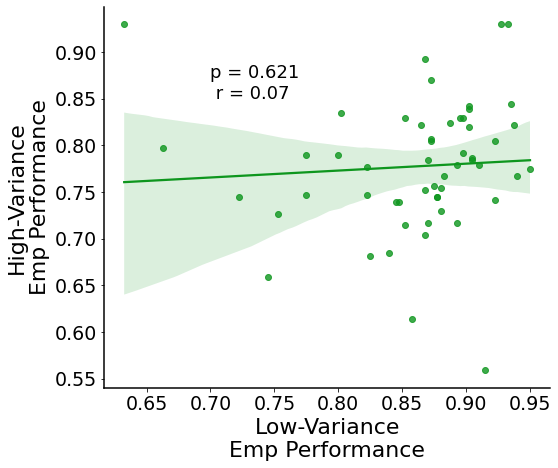

In [368]:
plt.figure(figsize=(8, 7))

df1 = df [df["model"] == "lv_induction"]
df2 = df[df["model"] == "hv_induction"]

temp_df = pd.merge(df1, df2, on =["subject"])

res = scipy.stats.pearsonr(temp_df["cor_x"], temp_df["cor_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))



seaborn.regplot(data=temp_df, x="cor_x", y="cor_y", color="#0E961E")

plt.ylabel("High-Variance\nEmp Performance", fontsize=22)
plt.xlabel("Low-Variance\nEmp Performance", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(0.7, .85, "p = {:.3f} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/Corss_task_correlation_emp_perf.png", dpi=400, bbox_inches='tight')


plt.show()

In [113]:
print(",".join([str(a) for a in temp_df["cor_x"]]))
print(",".join([str(a) for a in temp_df["cor_y"]]))


0.78445,0.8081,0.7592,0.7546,0.76,0.7675,0.7768,0.73215,0.781125,0.7693,0.772575,0.78565,0.7935,0.675275,0.7922,0.798,0.69735,0.757075,0.784025,0.787475,0.7507,0.782,0.791025,0.76415,0.8005,0.5269,0.797925,0.730175,0.7987,0.742225,0.782375,0.668675,0.7595,0.772,0.76975,0.797875,0.773925,0.77875,0.74895,0.763475,0.79265,0.7703,0.776,0.78185,0.795375,0.7698,0.749325,0.776975,0.7821,0.771875,0.7762,0.786025,0.74525,0.79275
0.6364661654135338,0.6798245614035088,0.6918045112781955,0.6735087719298246,0.623483709273183,0.6973182957393483,0.6751629072681704,0.6372932330827068,0.7014786967418546,0.6847117794486216,0.7024310776942356,0.7117543859649123,0.6892481203007519,0.6796992481203008,0.6823308270676691,0.7023558897243107,0.7259398496240601,0.6756892230576441,0.6977443609022557,0.5916791979949875,0.6800250626566416,0.6610526315789473,0.6866165413533835,0.6851378446115288,0.6861152882205513,0.6971177944862156,0.6969423558897243,0.6527568922305764,0.6794987468671679,0.6845614035087719,0.70015

(p = 7.47e-01, r = -0.05, ci = [-0.31,0.23])


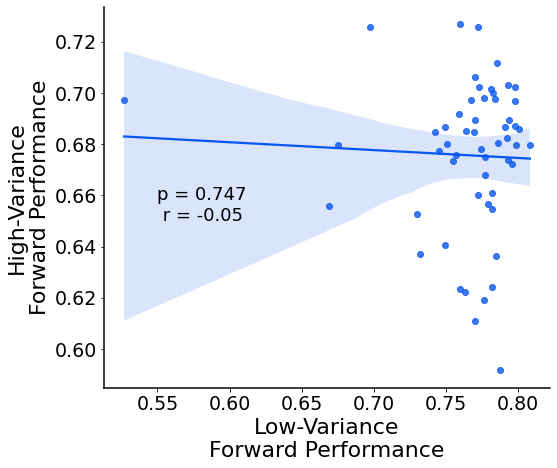

In [110]:
plt.figure(figsize=(8, 7))

df1 = df [df["model"] == "lv_induction"]
df2 = df[df["model"] == "hv_induction"]

temp_df = pd.merge(df1, df2, on =["subject"])

res = scipy.stats.pearsonr(temp_df["accuracy_x"], temp_df["accuracy_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))



seaborn.regplot(data=temp_df, x="accuracy_x", y="accuracy_y", color="#0957F1")

plt.ylabel("High-Variance\nForward Performance", fontsize=22)
plt.xlabel("Low-Variance\nForward Performance", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(0.55, .65, "p = {:.3f} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/Corss_task_correlation_forward_perf.png", dpi=400, bbox_inches = "tight")


plt.show()

(p = 3.36e-03, r = 0.39, ci = [0.14,0.60])


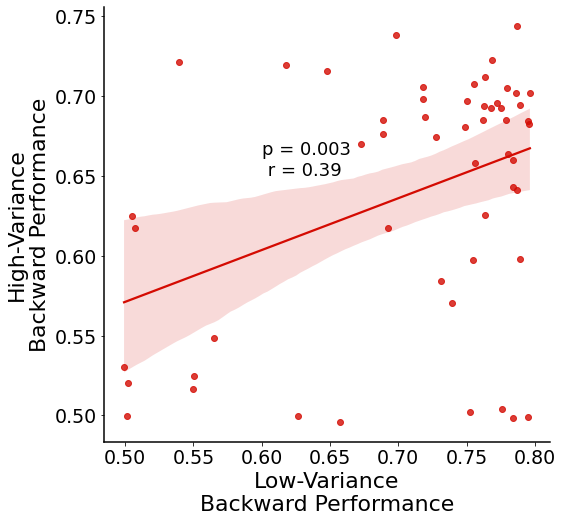

In [367]:
plt.figure(figsize=(8, 8))

df1 = back_df [back_df["model"] == "lv_induction"]
df2 = back_df[back_df["model"] == "hv_induction"]

temp_df = pd.merge(df1, df2, on =["subject"])

res = scipy.stats.pearsonr(temp_df["accuracy_x"], temp_df["accuracy_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))



seaborn.regplot(data=temp_df, x="accuracy_x", y="accuracy_y", color="#D40B02")

plt.ylabel("High-Variance\nBackward Performance", fontsize=22)
plt.xlabel("Low-Variance\nBackward Performance", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(0.6, .65, "p = {:.3f} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/Corss_task_correlation_backward_perf.png", dpi=400, bbox_inches = "tight")


plt.show()

(p = 1.06e-02, r = 0.35, ci = [0.09,0.56])


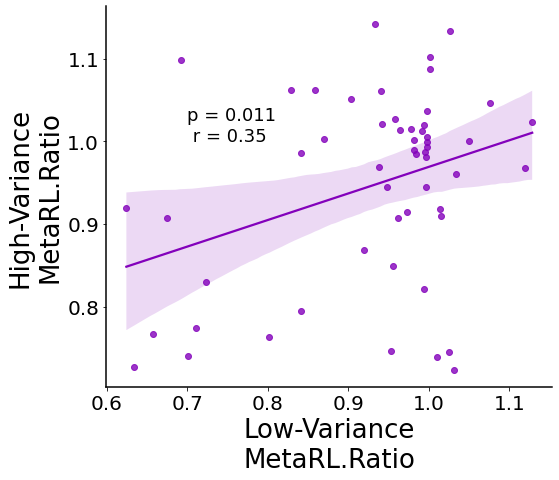

In [407]:
plt.figure(figsize=(8, 7))

df1 = mrl_df[mrl_df["model"] == "lv_induction"]
df2 = mrl_df[mrl_df["model"] == "hv_induction"]

temp_df = pd.merge(df1, df2, on =["subject"])

res = scipy.stats.pearsonr(temp_df["mrl_ratio_x"], temp_df["mrl_ratio_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))



seaborn.regplot(data=temp_df, x="mrl_ratio_x", y="mrl_ratio_y", color="#8301BB")

plt.ylabel("High-Variance\nMetaRL.Ratio", fontsize=26)
plt.xlabel("Low-Variance\nMetaRL.Ratio", fontsize=26)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(.7, 1, "p = {:.3f} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/Corss_task_correlation_MRL.png", dpi=400, bbox_inches = "tight")


plt.show()

In [408]:
stat

0.34509707495693626

(p = 6.21e-01, r = 0.07, ci = [-0.20,0.33])
(p = 7.47e-01, r = -0.05, ci = [-0.31,0.23])
(p = 3.36e-03, r = 0.39, ci = [0.14,0.60])


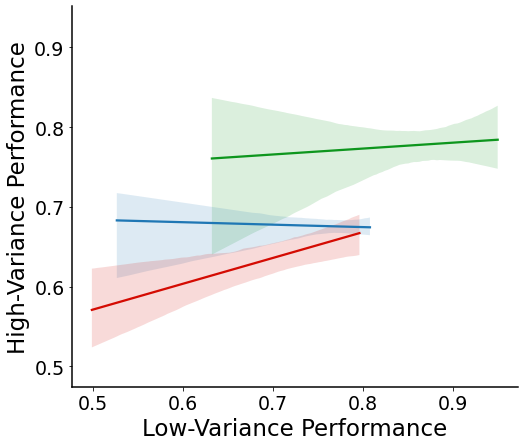

In [377]:
plt.figure(figsize=(8, 7))

df1 = df [df["model"] == "lv_induction"]
df2 = df[df["model"] == "hv_induction"]

temp_df = pd.merge(df1, df2, on =["subject"])

res = scipy.stats.pearsonr(temp_df["cor_x"], temp_df["cor_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))



seaborn.regplot(data=temp_df, x="cor_x", y="cor_y", color="#0E961E", scatter_kws={"color": "white"})

df1 = df [df["model"] == "lv_induction"]
df2 = df[df["model"] == "hv_induction"]

temp_df = pd.merge(df1, df2, on =["subject"])

res = scipy.stats.pearsonr(temp_df["accuracy_x"], temp_df["accuracy_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))



seaborn.regplot(data=temp_df, x="accuracy_x", y="accuracy_y", scatter_kws={"color": "white", "alpha": 0})


df1 = back_df [back_df["model"] == "lv_induction"]
df2 = back_df[back_df["model"] == "hv_induction"]

temp_df = pd.merge(df1, df2, on =["subject"])

res = scipy.stats.pearsonr(temp_df["accuracy_x"], temp_df["accuracy_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))



seaborn.regplot(data=temp_df, x="accuracy_x", y="accuracy_y", color="#D40B02", scatter_kws={"color": "white", "alpha": 0})



plt.ylabel("High-Variance Performance", fontsize=23)
plt.xlabel("Low-Variance Performance", fontsize=23)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
# plt.text(0.7, .85, "p = {:.3f} \n r = {:.2f}".format(pval, stat), fontsize=18)

# plt.savefig("../figs/Corss_task_correlation_emp_perf.png", dpi=400, bbox_inches='tight')


plt.show()